In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [136]:
import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

from functools import partial
from tqdm import tqdm
from scipy.stats import spearmanr, permutation_test, mannwhitneyu, PermutationMethod, false_discovery_control, rankdata
ATLAS = "AAL+CSF"
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

TEN_PERCENT = 0.1
FIVE_PERCENT = 0.05
ONE_PERCENT = 0.01

In [3]:
def statistic(x, y, dof, axis=0):  # explore all possible pairings by permuting `x`
    rs = spearmanr(x, y, axis=axis).statistic  # ignore pvalue
    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    return transformed

def run_correlation_analysis(samples,
                             roi_score_threshold_quantile=0.8,
                             relevant_roi_columns = None,
                             correlation_thresh=0.5,
                             n_resamples=10_000):
    
    # Only keep ROIs above reference threshold on average
    if relevant_roi_columns is None:
        roi_thresh = reference_likelihoods.quantile(roi_score_threshold_quantile)
        relevant_roi_columns = samples[reference_likelihoods.columns].mean() > roi_thresh
        relevant_roi_columns = list(relevant_roi_columns[relevant_roi_columns == True].index)
    
    msma_scores = samples[relevant_roi_columns]
    behavior_scores = samples[behavior_cols]
    corrmatrix, _ = spearmanr(msma_scores, behavior_scores)
    featnames = relevant_roi_columns+behavior_cols
    corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
    
    dof = len(samples) - 2
    corrs = corrmatrix.loc[relevant_roi_columns, behavior_cols].stack()
#     significant_correlation = (corrs.abs() > correlation_thresh).values
#     corrs = corrs[significant_correlation]

    print("Running permutation test ... ")
    print(f"Correlation Threshold: {correlation_thresh}")
    print(f"Feature Pairs: {corrs.shape[0]} ")
    print(f"Maximum DOF: {dof} ")
    
    sigcorrs = []
    for row in tqdm(corrs.items()):
        (roi, bhv), corr = row
        x,y = samples[roi], samples[bhv]
        nonmissing = y > -1
        x,y = x[nonmissing], y[nonmissing]
        dof = len(x) - 2
        
        ref = permutation_test((x, ), partial(statistic, y=y, dof=dof), vectorized=False,
                               n_resamples=n_resamples, alternative='two-sided', permutation_type='pairings')
        sigcorrs.append((roi, bhv, corr, ref.pvalue, len(y)))
    
    sigcorrdf = pd.DataFrame(sigcorrs, columns=['ROI', "Behavior", "Corr", "p-value", "nsamples"]
                                ).sort_values(by='Corr', ascending=False, key=lambda x: abs(x))#.set_index(['ROI', 'Behavior'])
    
    return corrmatrix, sigcorrdf, relevant_roi_columns

## Loading Voxel-wise Scores

In [4]:
roi_score_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods.csv")
roi_columns = roi_score_likelihoods.columns.difference(['Cohort', "ID"])
roi_score_likelihoods.describe()

background         CSF  Precentral_L  Precentral_R  Frontal_Sup_L  \
count  319.000000  319.000000    319.000000    319.000000     319.000000   
mean   -52.319597   -0.377818    -16.516151    -16.224555     -13.818043   
std      3.546803    1.228652      1.456727      1.556727       1.815214   
min    -56.578876   -2.319088    -18.865427    -19.293846     -16.664347   
25%    -54.264077   -1.154375    -17.479531    -17.163305     -14.953725   
50%    -53.372475   -0.594116    -16.710178    -16.546534     -14.171143   
75%    -51.783491   -0.008909    -15.920045    -15.728770     -13.174180   
max    -27.150005    7.890209     -5.713173     -5.071681      -2.370178   

       Frontal_Sup_R  Frontal_Sup_Orb_L  Frontal_Sup_Orb_R  Frontal_Mid_L  \
count     319.000000         319.000000         319.000000     319.000000   
mean      -14.786558          -7.952232          -7.362655     -14.798461   
std         1.858061           1.738513           1.847489       1.813877   
min       -17.834581         -11.162533         -10.705958     -17.992964   
25%       -16.054201          -9.079662          -8.609350     -15.953917   
50%       -15.222399          -8.296599          -7.697394     -15.106338   
75%       -14.250692          -7.268675          -6.743108     -14.188337   
max        -3.197154          -0.232863           2.750425      -4.293357   

       Frontal_Mid_R  ...  Cerebelum_10_L  Cerebelum_10_R  Vermis_1_2  \
count     319.000000  ...      319.000000      319.000000  319.000000   
mean      -14.637856  ...       -3.204714       -2.568465    1.004282   
std         1.835720  ...        1.930059        2.248261    3.632817   
min       -17.878504  ...       -8.171700       -6.777907   -7.101626   
25%       -15.746493  ...       -4.510982       -4.010949   -1.564713   
50%       -15.056453  ...       -3.428044       -3.018079    0.242059   
75%       -14.231890  ...       -2.331557       -1.634686    3.056741   
max        -1.176398  ...        4.721942        7.006848   13.638239   

         Vermis_3  Vermis_4_5    Vermis_6    Vermis_7    Vermis_8    Vermis_9  \
count  319.000000  319.000000  319.000000  319.000000  319.000000  319.000000   
mean    -3.963514  -10.803113  -13.258068  -14.839645  -14.311450  -11.692039   
std      2.708830    1.821178    2.177873    2.238607    1.970837    2.600565   
min    -11.365950  -14.709953  -17.588547  -18.750265  -18.642620  -16.613453   
25%     -5.904717  -12.017765  -14.647789  -16.358936  -15.575236  -13.279220   
50%     -4.043064  -10.996241  -13.579793  -15.144185  -14.677023  -12.035291   
75%     -2.266750   -9.938312  -12.436849  -13.679595  -13.352628  -10.477822   
max      8.454497    0.980924    0.889772   -1.840893   -5.027266    1.283823   

        Vermis_10  
count  319.000000  
mean     1.828034  
std      2.952854  
min     -5.228525  
25%     -0.073873  
50%      1.782930  
75%      3.719014  
max     10.714840  

[8 rows x 118 columns]

In [5]:
reference_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv")
reference_likelihoods

background       CSF  Precentral_L  Precentral_R  Frontal_Sup_L  \
0    -52.405773 -1.160594    -16.240720    -15.420356     -13.174262   
1    -53.402084  0.589674    -16.218039    -16.240524     -12.814417   
2    -53.377735  0.354789    -16.782894    -15.423598     -13.801647   
3    -53.366486 -1.123906    -14.828829    -16.024061     -11.564390   
4    -54.079800 -0.805278    -15.471673    -15.820291     -12.870411   
..          ...       ...           ...           ...            ...   
325  -56.249020 -2.643489    -16.350897    -16.684572     -14.756400   
326  -52.580654 -0.585214    -14.549687    -15.862584     -13.132694   
327  -51.015700  0.189976    -16.854430    -16.476469     -14.186939   
328  -57.438920 -2.173401    -17.137371    -16.613934     -14.874028   
329  -53.114166 -1.181961    -16.999947    -17.979078     -15.339323   

     Frontal_Sup_R  Frontal_Sup_Orb_L  Frontal_Sup_Orb_R  Frontal_Mid_L  \
0       -14.156552          -7.823804          -4.615128     -14.945374   
1       -14.059655          -6.404532          -6.504943     -14.161819   
2       -13.938385          -6.296635          -6.754046     -14.851440   
3       -11.740133          -6.887378          -7.011018     -13.014995   
4       -12.842586          -9.030422          -6.099383     -14.213899   
..             ...                ...                ...            ...   
325     -15.867616          -9.001400          -8.668185     -15.575353   
326     -13.948072          -9.040503          -7.104403     -13.877936   
327     -14.068050          -7.800881          -5.969154     -15.419061   
328     -15.464175          -9.022839         -10.262229     -17.379310   
329     -15.572917          -8.888371          -9.644242     -16.351866   

     Frontal_Mid_R  ...  Cerebelum_10_L  Cerebelum_10_R  Vermis_1_2  Vermis_3  \
0       -14.115917  ...        0.274043       -1.931260   -2.772257 -1.809489   
1       -14.106808  ...        1.904382        0.368827    0.593147 -7.963304   
2       -14.423994  ...       -2.394596        1.226850    2.177078 -3.667122   
3       -13.505042  ...       -2.102789       -4.208999   -5.066557 -7.836586   
4       -13.620967  ...       -1.462058       -2.483546   -0.818634 -7.150911   
..             ...  ...             ...             ...         ...       ...   
325     -16.849012  ...       -4.610546       -2.590799    0.633469 -2.560068   
326     -14.395870  ...       -5.449009       -3.158637    3.477614 -6.643682   
327     -13.989452  ...       -1.912146       -2.117533    1.705959 -4.996028   
328     -15.883713  ...       -2.271553       -4.780619   -0.245777 -5.563844   
329     -15.753854  ...       -0.570083       -4.253496   -1.804143 -5.885356   

     Vermis_4_5   Vermis_6   Vermis_7   Vermis_8   Vermis_9  Vermis_10  
0    -12.854198  -9.614663 -10.075984  -9.784621 -13.246734  -0.820748  
1     -8.854574 -13.252735 -10.851413  -9.404264  -8.134412   2.729643  
2     -8.187992 -14.593800 -17.832844 -13.660639  -9.626647   7.527297  
3    -11.836378 -15.871938 -17.315775 -16.632887 -13.647439  -0.835417  
4    -14.199053 -14.393287  -9.442236  -8.504608 -10.238399   2.698345  
..          ...        ...        ...        ...        ...        ...  
325  -10.341605 -11.887557 -13.747066 -12.237647 -12.317142   3.320579  
326   -9.087432 -10.681849 -12.933929 -16.553982 -14.615436   0.704811  
327  -10.097131 -12.048326 -11.650540 -12.399459 -10.757129  11.106877  
328  -11.853545 -11.206584 -15.898020 -15.389916  -9.948182   3.416188  
329  -10.508652 -12.445095 -13.799177 -12.989284  -9.682922   4.664731  

[330 rows x 118 columns]

In [6]:
ibis_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ibis_metadata.csv")
ibis_metadata.index = ibis_metadata["CandID"].apply(lambda x: "IBIS" + str(x))
ibis_metadata.index.name = "ID"
ibis_metadata = ibis_metadata.astype(np.float32, errors="ignore")

das_cols = [c for c in ibis_metadata.columns if "DAS" in c]
cbcl_cols = list(
    filter(
        lambda c: re.match(".*T_score", c),
        ibis_metadata.columns,
    )
)
vineland_cols = list(
    filter(lambda c: re.match(".*Vine.*STD", c), ibis_metadata.columns)
)
ados_cols = list(filter(lambda c: re.match(".*ADOS.*", c), ibis_metadata.columns))

behavior_cols = cbcl_cols + das_cols + vineland_cols + ados_cols

ibis_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 758 entries, IBIS389101 to IBIS624427
Data columns (total 77 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Identifiers                                                              758 non-null    object 
 1   V24 ADOS_Derived,restricted_repetitive_behavior_total                    758 non-null    float32
 2   V36 ADOS_Derived,restricted_repetitive_behavior_total                    758 non-null    float32
 3   V37Plus ADOS_Derived,restricted_repetitive_behavior_total                758 non-null    float32
 4   V24 ADOS_Derived,severity_score_lookup                                   758 non-null    float32
 5   V36 ADOS_Derived,severity_score_lookup                                   758 non-null    float32
 6   V37Plus ADOS_Derived,severity_score_lookup                     

In [7]:
das_cols

['VSA DAS_SA,PC_ABILITY_SCORE',
 'VSA DAS_SA,matrices_ABILITY_SCORE',
 'VSA DAS_SA,rd_ABILITY_SCORE',
 'VSA DAS_SA,seq_qr_ABILITY_SCORE',
 'VSA DAS_SA,verbal_similarities_ABILITY_SCORE',
 'VSA DAS_SA,word_defn_ABILITY_SCORE']

In [8]:
cbcl_cols

['aggr_behav_T_score',
 'anx_prob_T_score',
 'anxious_T_score',
 'attention_hyper_prob_T_score',
 'attention_prob_T_score',
 'conduct_prob_T_score',
 'depressed_T_score',
 'depressive_prob_T_score',
 'externalizing_T_score',
 'internalizing_T_score',
 'obsessive_comp_prob_T_score',
 'oppo_def_prob_T_score',
 'rule_break_behav_T_score',
 'sluggish_cogn_tempo_T_score',
 'social_prob_T_score',
 'som_comp_T_score',
 'som_prob_T_score',
 'stress_prob_T_score',
 'thought_prob_T_score',
 'total_problems_T_score']

In [9]:
vineland_cols

['Vineland_adapt_behave_comp_STD_SCORE',
 'Vineland_communication_STD_SCORE',
 'Vineland_daily_living_skills_STD_SCORE',
 'Vineland_socialization_STD_SCORE']

In [10]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

In [11]:
datadf = pd.merge(roi_score_likelihoods, ibis_metadata, on="ID").drop_duplicates(subset='ID')
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 318
Columns: 197 entries, background to Sex
dtypes: float32(71), float64(118), object(8)
memory usage: 399.9+ KB


In [12]:
datadf.to_csv("roi-msma.csv")

In [13]:
datadf[datadf.duplicated('ID')].Cohort

Series([], Name: Cohort, dtype: object)

In [14]:
datadf.query("Cohort == 'IBIS-DS'")['Sex']

0     Female
1       Male
3       Male
4       Male
5     Female
6     Female
7       Male
8     Female
9       Male
10      Male
12    Female
13    Female
14    Female
15      Male
16    Female
17    Female
19    Female
20    Female
21      Male
22    Female
23    Female
24      Male
26    Female
27      Male
28      Male
29      Male
30      Male
31      Male
Name: Sex, dtype: object

#### Not exactly Normal distributed => we should probably use a rank-order test

<Axes: ylabel='Frequency'>

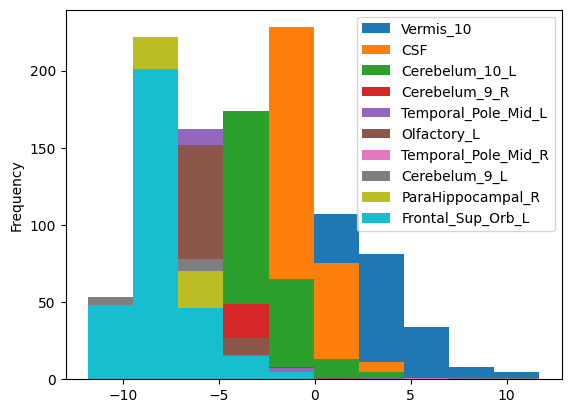

In [15]:
sorted_roi_columns = list(roi_score_likelihoods.mean(numeric_only=True).sort_values(ascending=False).index)
datadf[sorted_roi_columns[0:20:2]].plot(kind='hist')

In [16]:
# df[cbcl_cols].plot(kind='hist')

In [17]:
corrmatrix = datadf.corr(method='spearman')
corrmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, background to tbv_z_score
Columns: 189 entries, background to tbv_z_score
dtypes: float64(189)
memory usage: 284.6+ KB


/tmp/ipykernel_20498/2777923733.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmatrix = datadf.corr(method='spearman')


CPU times: user 219 ms, sys: 118 ms, total: 338 ms
Wall time: 186 ms


<Axes: >

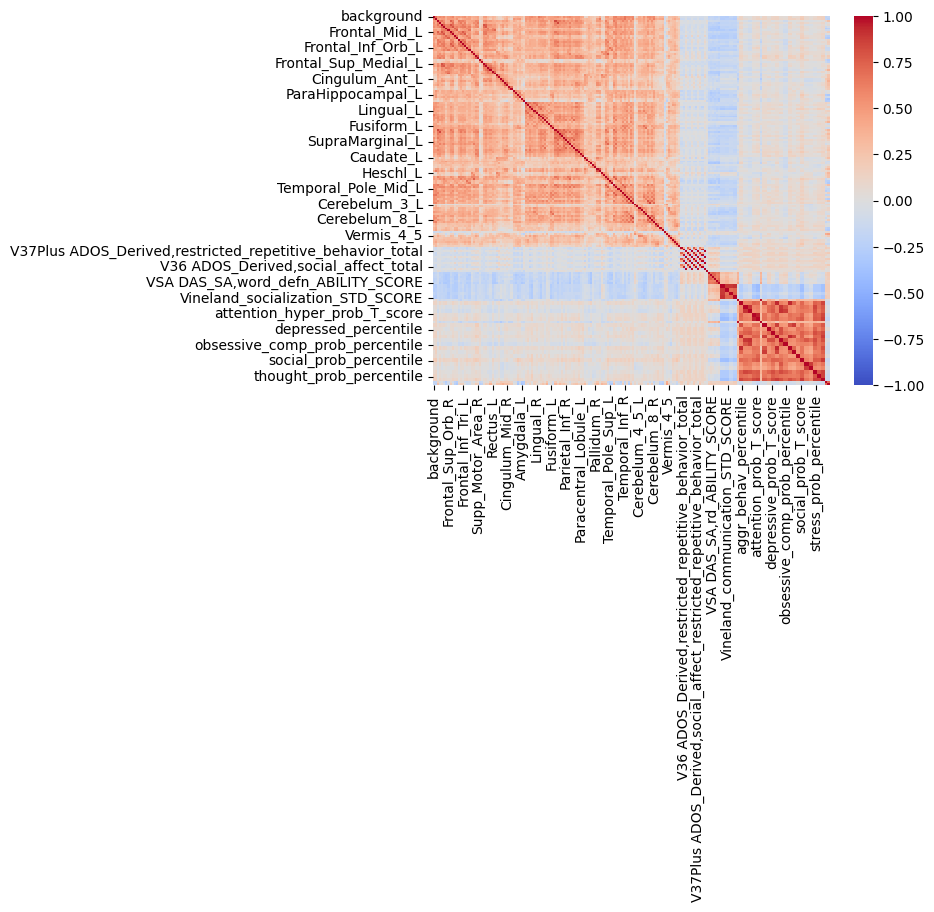

In [18]:
%%time
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)

In [19]:
msma_scores = datadf[sorted_roi_columns]
behavior_scores = datadf[behavior_cols]
corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = list(msma_scores.columns) + list(behavior_scores.columns)
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

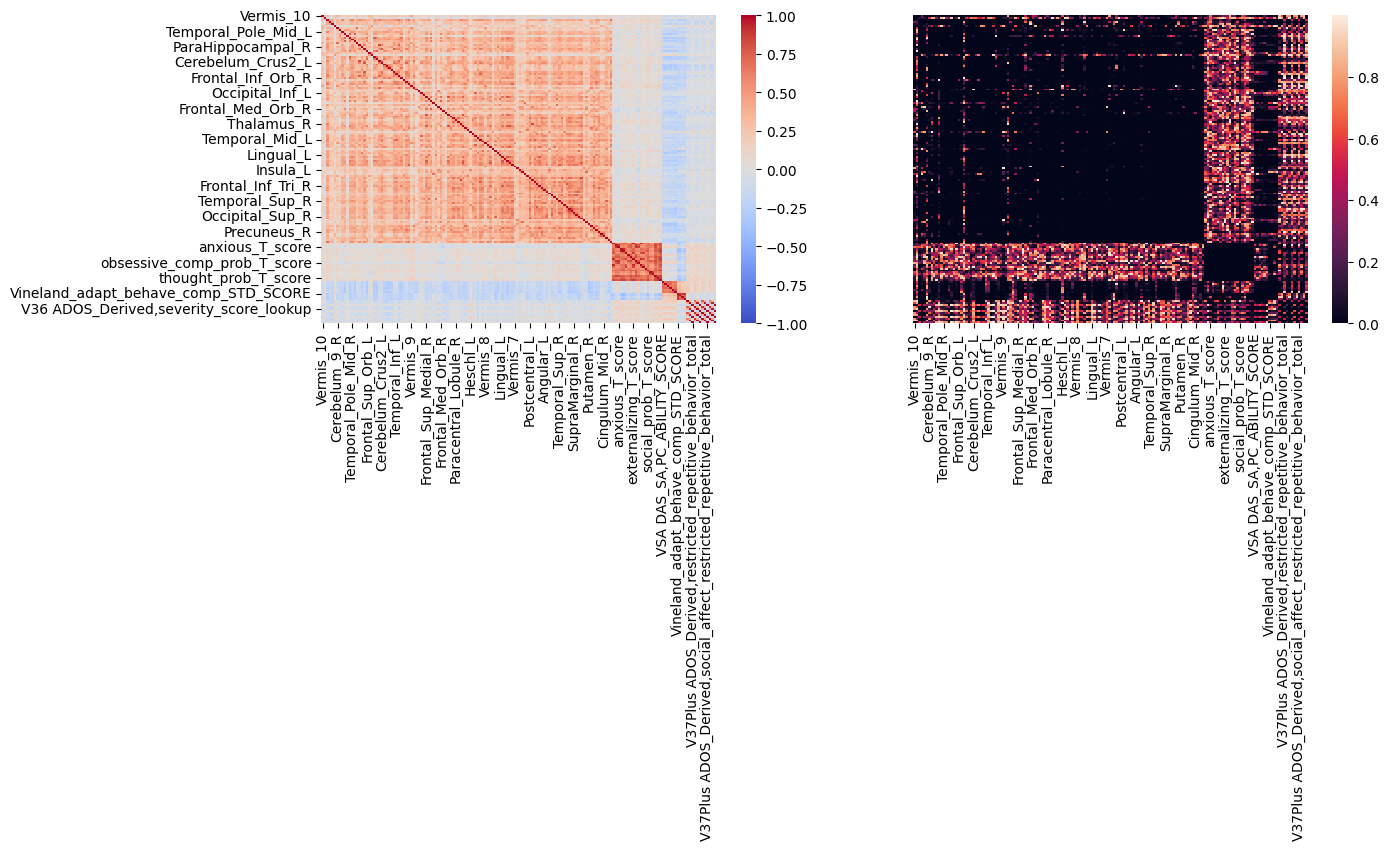

In [20]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
axs[1].yaxis.set_visible(False)

<Axes: >

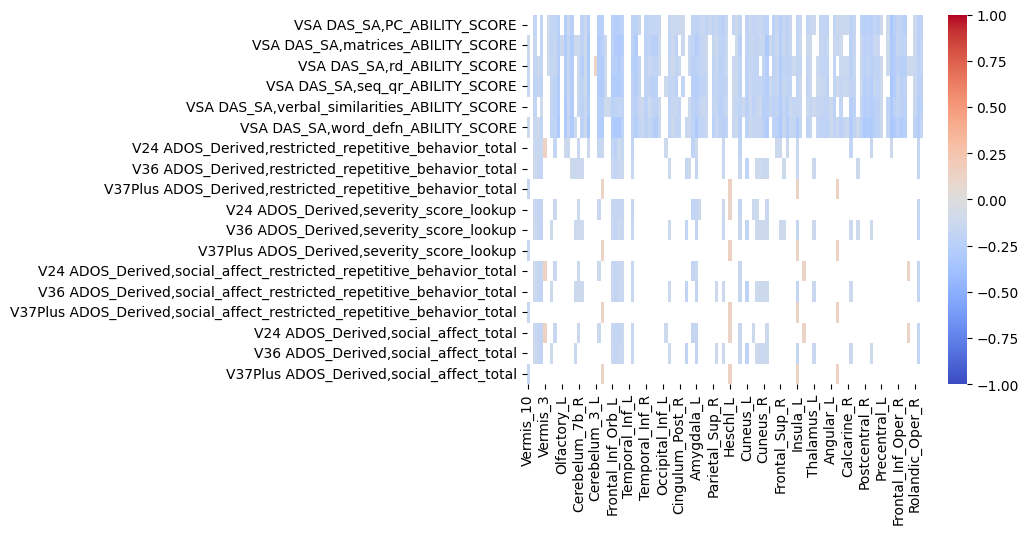

In [21]:
significant = pvalues < 0.05
sns.heatmap(corrmatrix[significant].loc[das_cols+ados_cols, sorted_roi_columns, ],  cmap='coolwarm', vmin=-1, vmax=1, )

## Separating into Atypical Cohorts

In [22]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

/tmp/ipykernel_20498/943745522.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  roi_score_likelihoods.pivot_table(columns='Cohort').plot.hist(bins=50)


<Axes: ylabel='Frequency'>

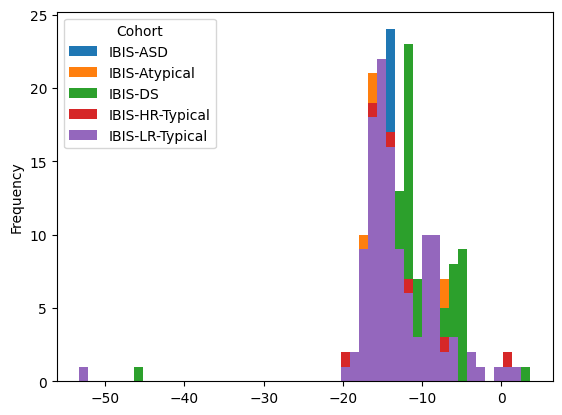

In [23]:
roi_score_likelihoods.pivot_table(columns='Cohort').plot.hist(bins=50)

In [24]:
plotdf = roi_score_likelihoods.query("Cohort == 'IBIS-DS' | Cohort == 'IBIS-LR-Typical'")[list(roi_columns) + ['Cohort']].pivot_table(columns='Cohort')
plotdf = plotdf.melt()
plotdf.head()

Cohort      value
0  IBIS-DS -11.306047
1  IBIS-DS -10.672110
2  IBIS-DS -13.674785
3  IBIS-DS -14.140289
4  IBIS-DS   2.046153

In [25]:
np.arange(1,-20,-1)

array([  1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11,
       -12, -13, -14, -15, -16, -17, -18, -19])

<Axes: xlabel='value', ylabel='Density'>

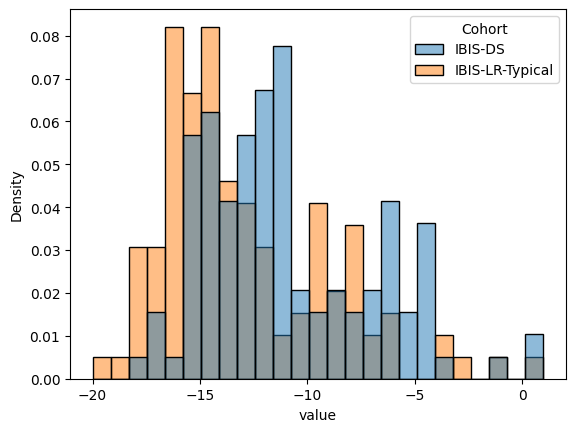

In [26]:
sns.histplot(plotdf, x='value', hue='Cohort', kde=False, stat='density', binrange=(-20,1), bins=25)

In [27]:
atypicals = datadf[datadf['Cohort'].isin(['IBIS-DS'])]
msma_scores = atypicals[sorted_roi_columns]
behavior_scores = atypicals[behavior_cols]

corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = sorted_roi_columns+behavior_cols
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [28]:
# behavior_scores[cbcl_cols].plot(kind='hist', subplots=True, layout=(5,4), figsize=(12,12))

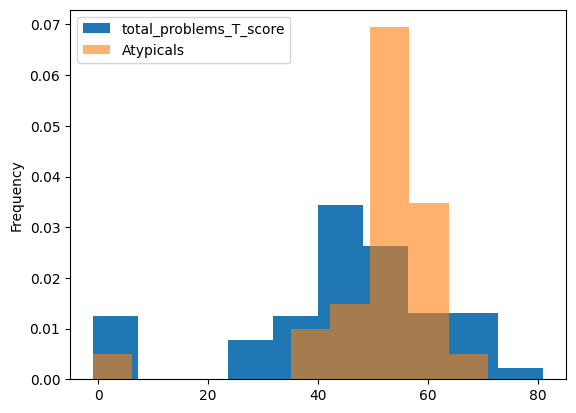

In [29]:
datadf['total_problems_T_score'].plot(kind='hist', density=True)
behavior_scores['total_problems_T_score'].plot(kind='hist', density=True,label="Atypicals", alpha=0.6)
plt.legend()

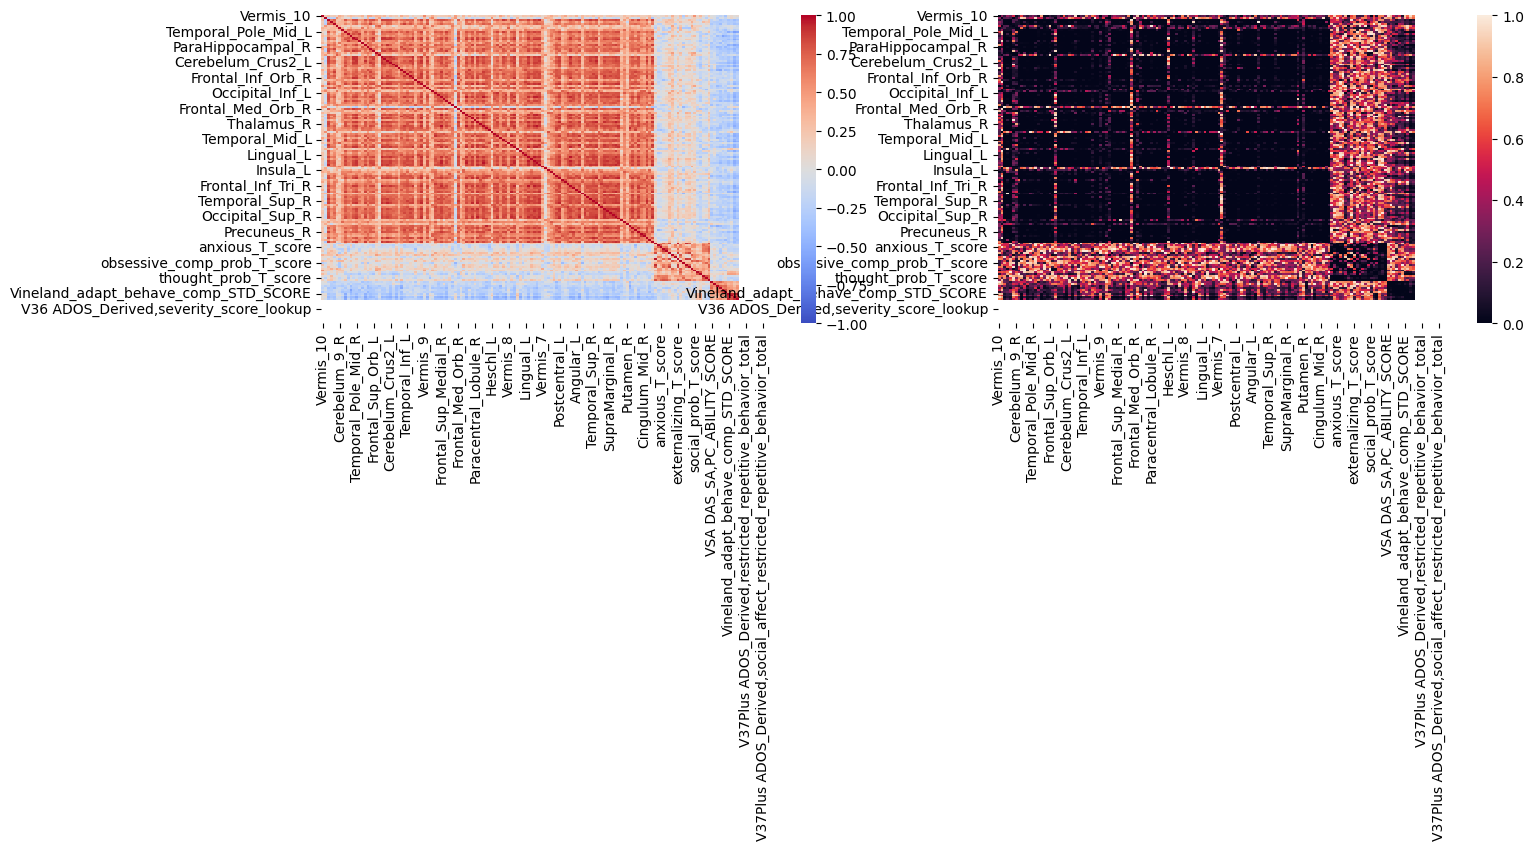

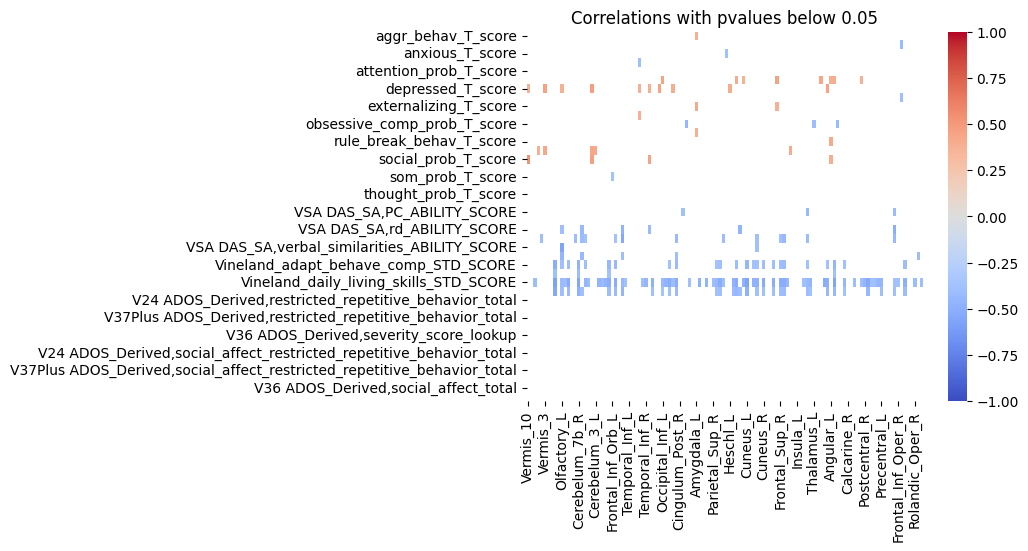

In [30]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
plt.show()

pval = 0.05
significant = pvalues < pval
sns.heatmap(corrmatrix[significant].loc[behavior_cols, sorted_roi_columns],  cmap='coolwarm',
            vmin=-1, vmax=1, )
plt.title(f"Correlations with pvalues below {pval}");

### Correlations between different behavior scores

In [31]:
cval = 0.4
significant_correlation = corrmatrix.abs() > cval

Text(0.5, 1.0, 'Absolute correlations above 0.4')

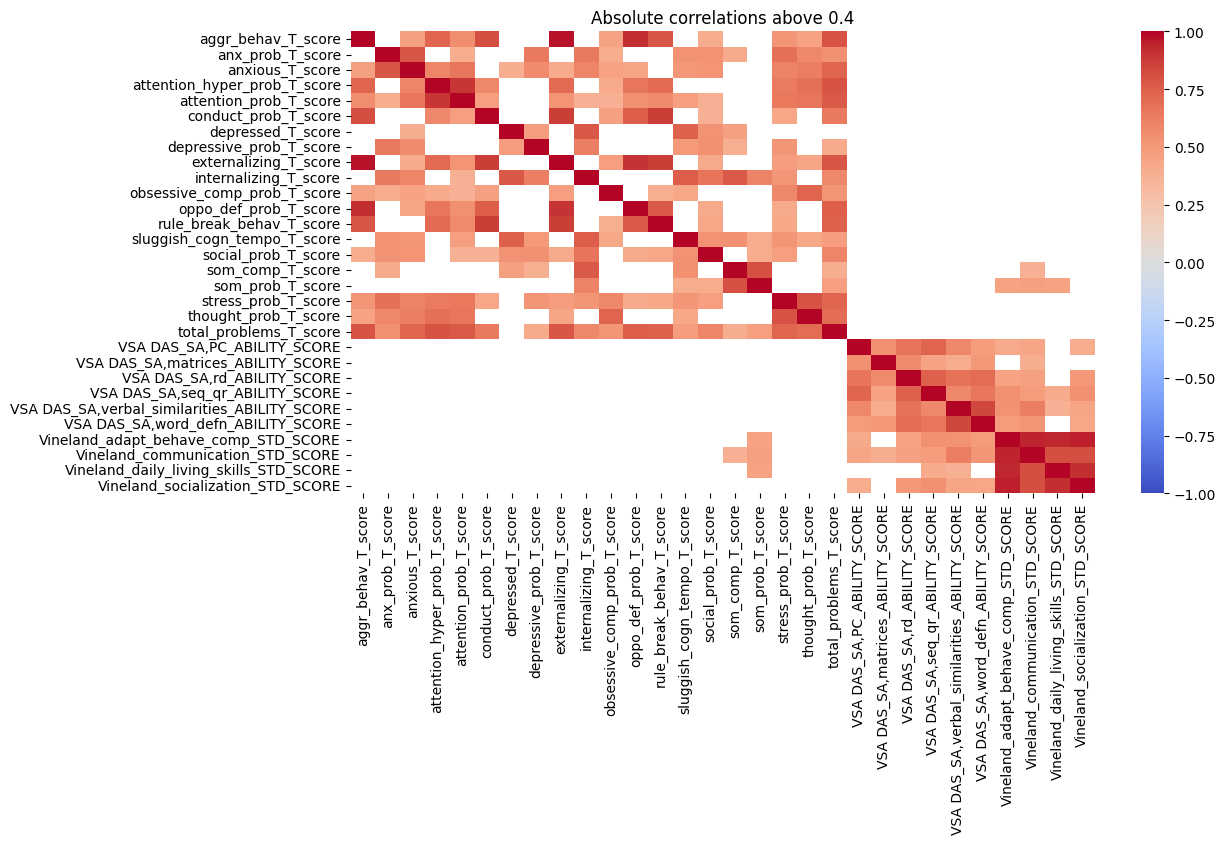

In [32]:
corrs = corrmatrix[significant].loc[behavior_cols, behavior_cols]
keepcols = corrs.count()[corrs.count() > 2].index
plt.figure(figsize=(12,6))
sns.heatmap(corrs.loc[keepcols, keepcols],cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

<Axes: >

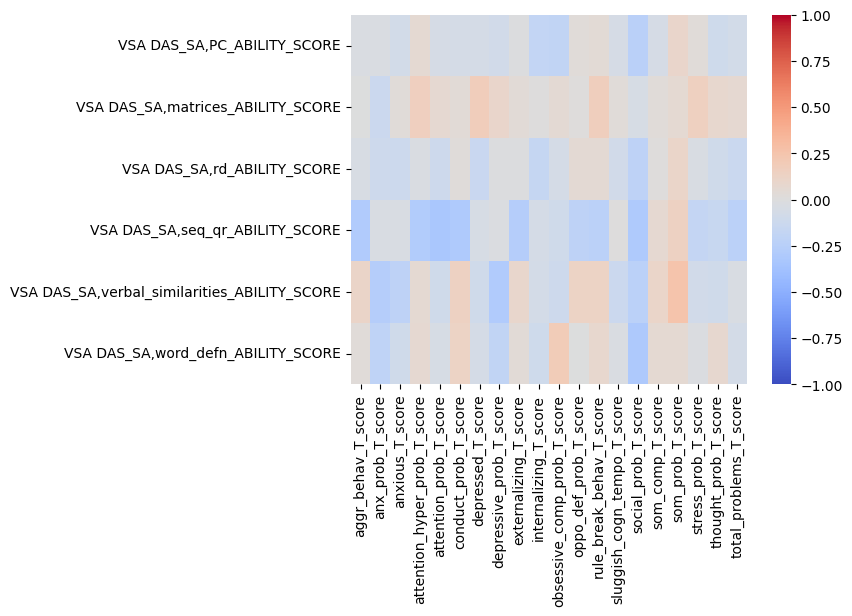

In [33]:
sns.heatmap(corrmatrix.loc[das_cols, cbcl_cols],cmap='coolwarm', vmin=-1, vmax=1)

Text(0.5, 1.0, 'Absolute correlations above 0.4')

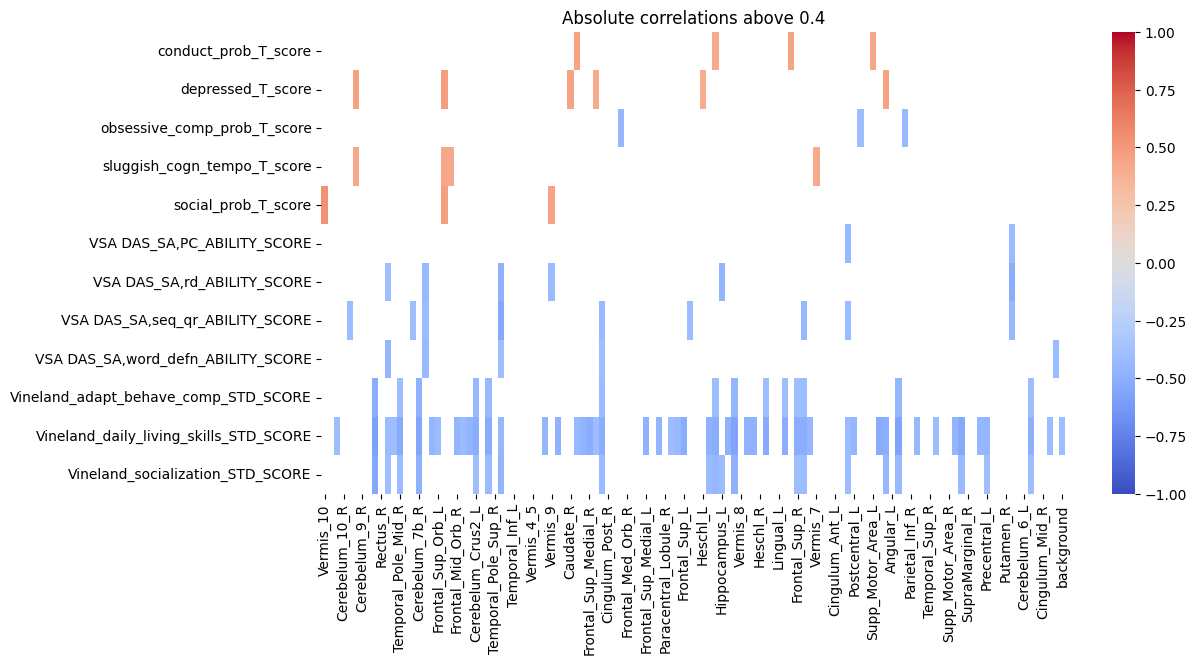

In [34]:
corrs = corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols]
keepcols = corrs.count()[corrs.count() > 1].index
plt.figure(figsize=(12,6))
sns.heatmap(corrmatrix[significant_correlation].loc[keepcols, sorted_roi_columns],
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

### Which Assessment shows high correlation with MSMA scores?

In [35]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols].count(axis='rows').sort_values(ascending=False)[:10]

Vineland_daily_living_skills_STD_SCORE    51
Vineland_socialization_STD_SCORE          20
Vineland_adapt_behave_comp_STD_SCORE      14
VSA DAS_SA,seq_qr_ABILITY_SCORE            9
depressed_T_score                          6
VSA DAS_SA,rd_ABILITY_SCORE                6
VSA DAS_SA,word_defn_ABILITY_SCORE         5
sluggish_cogn_tempo_T_score                4
conduct_prob_T_score                       4
obsessive_comp_prob_T_score                3
dtype: int64

<Axes: >

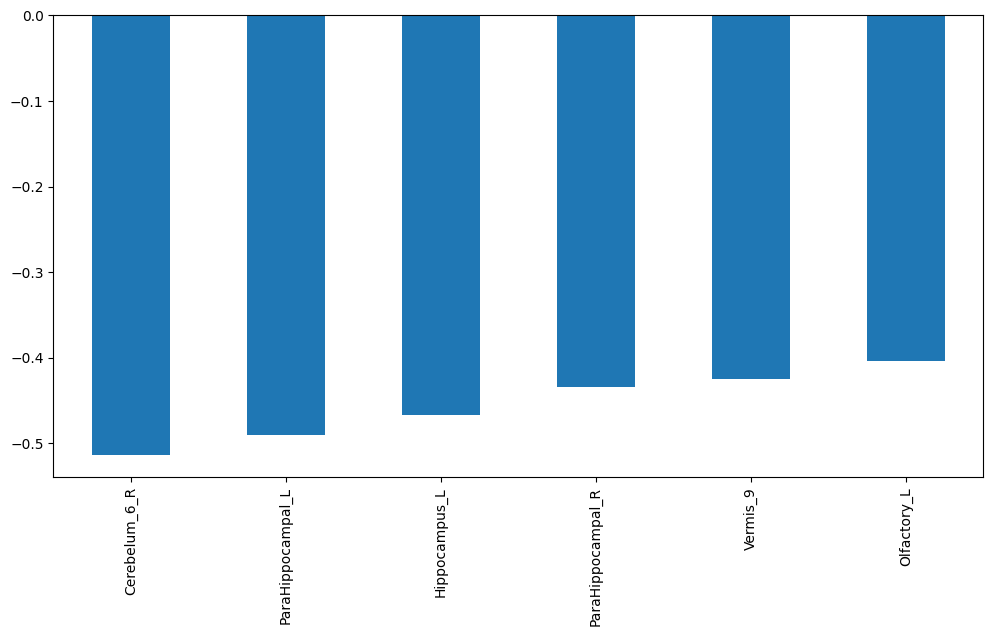

In [36]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, 'VSA DAS_SA,rd_ABILITY_SCORE'].dropna().sort_values().plot(kind='bar', figsize=(12,6))

In [37]:
spearmanr(msma_scores['Cerebelum_6_R'], behavior_scores['VSA DAS_SA,rd_ABILITY_SCORE'])

SignificanceResult(statistic=-0.5139494745662078, pvalue=0.0051477238446801035)

In [38]:
%%time
x,y = msma_scores['Cerebelum_8_R'], behavior_scores['VSA DAS_SA,seq_qr_ABILITY_SCORE']
ref = permutation_test((x, ), partial(statistic, y=y, dof=len(msma_scores)), vectorized=False,
                       alternative='two-sided', permutation_type='pairings')

CPU times: user 10.2 s, sys: 2.73 ms, total: 10.2 s
Wall time: 10.2 s


In [39]:
ref

PermutationTestResult(statistic=-0.7520698905038166, pvalue=0.4722, null_distribution=array([-0.2045491 , -2.15126417,  0.01021984, ..., -1.24169563,
        1.23695042,  0.73402943]))

In [40]:
plotdf = datadf.copy()
plotdf[sorted_roi_columns+behavior_cols] = plotdf[sorted_roi_columns+behavior_cols].apply(rankdata)

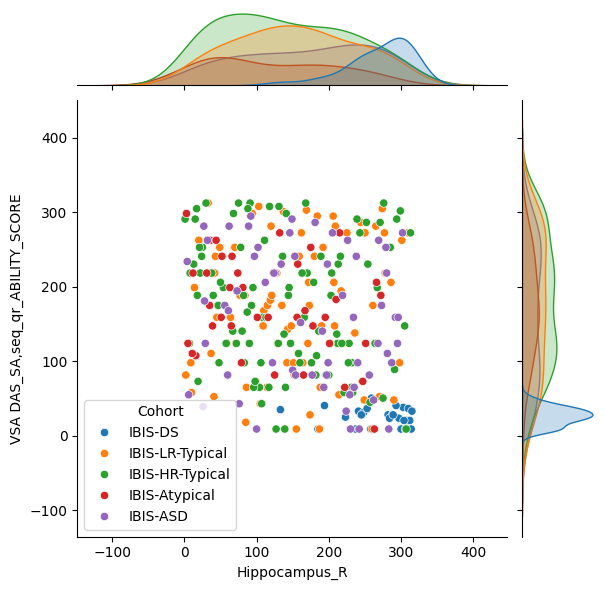

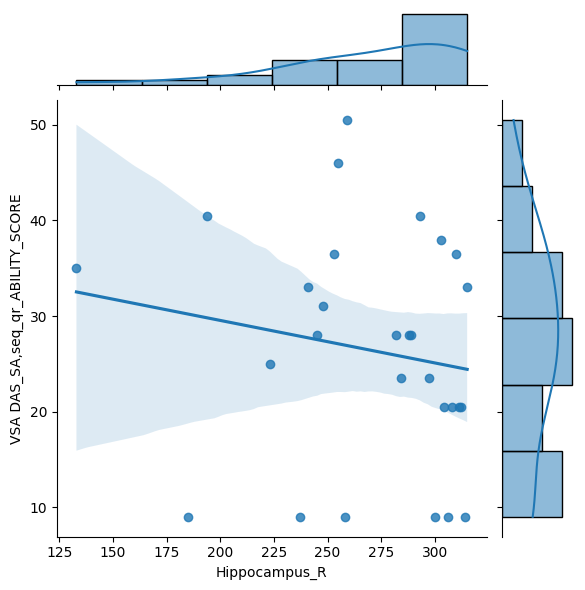

In [41]:
sns.jointplot(x='Hippocampus_R', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf, hue='Cohort',)
plt.show()
sns.jointplot(x='Hippocampus_R', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf.query("Cohort == 'IBIS-DS'"), kind='reg',)

In [42]:
plotdf.query("Cohort == 'IBIS-DS'").Sex.value_counts()

Female    14
Male      14
Name: Sex, dtype: int64

# DS-Prototype Samples 

In [43]:
dssamples = datadf.query("Cohort == 'IBIS-DS'")
ds_prototype_ids = pd.read_csv("/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/SOM/13x13_ds_protoype.csv")['ID']
prot_ids_set = set(ds_prototype_ids)
ds_prototypes = dssamples.merge(ds_prototype_ids, on='ID')
ds_non_prototypes = dssamples[~dssamples['ID'].isin(ds_prototype_ids)]
len(ds_prototypes), len(ds_non_prototypes)

(16, 12)

In [44]:
# ds_prototypes.corr()['depressed_percentile'][roi_columns].sort_values()

/tmp/ipykernel_20498/2368612405.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ds_prototypes.corr(), center=0)


<Axes: >

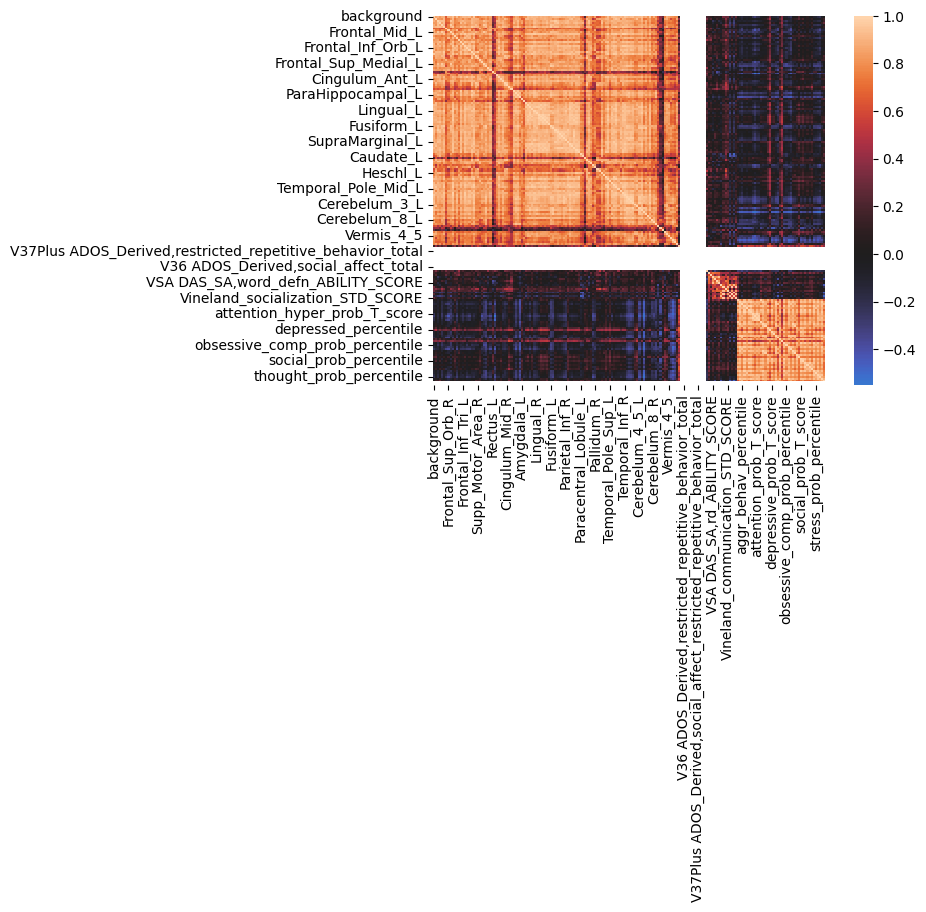

In [45]:
sns.heatmap(ds_prototypes.corr(), center=0)

In [46]:
relevant_rois = datadf.query("Cohort == 'IBIS-DS'")[roi_columns].mean() > datadf.query("Cohort == 'IBIS-LR-Typical'")[roi_columns].quantile(0.9)
relevant_rois = relevant_rois.index[relevant_rois]
relevant_rois = relevant_rois.drop(['background'])
len(relevant_rois)

71

In [47]:
%%time
np.random.seed(42)
statistics = []

for c in tqdm(relevant_rois):
    statistics.append(
        mannwhitneyu(ds_prototypes[c], ds_non_prototypes[c],
                     method=PermutationMethod(n_resamples=10_000))
    )

100%|██████████| 71/71 [00:03<00:00, 20.55it/s]

CPU times: user 3.16 s, sys: 376 ms, total: 3.53 s
Wall time: 3.46 s


In [48]:
pvals = np.asarray([s.pvalue for s in statistics])
adjusted_ps = false_discovery_control(pvals, method='bh')
alpha = 0.01
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")
alpha = FIVE_PERCENT
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")

FDR: 0.01 -> Significant ROIs: 55 / 71
FDR: 0.05 -> Significant ROIs: 60 / 71


## Using Bonferoni Correction

In [49]:
ntests = len(pvals)
alphacBonf = alpha / float(ntests)
pvals_corrected = pvals * float(ntests)

In [50]:
significant_prototype_rois = [roi for roi, pval in zip(relevant_rois, pvals) if pval < alphacBonf]
len(significant_prototype_rois)

40

In [51]:
dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})
dssamples['Subpopulation'].value_counts()

/tmp/ipykernel_20498/4167399050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
/tmp/ipykernel_20498/4167399050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})


Maximal-Prototype    16
Non-Prototype        12
Name: Subpopulation, dtype: int64

In [52]:
# n_sleect = 
prototype_rois = pd.DataFrame(np.stack([relevant_rois, pvals, pvals_corrected], axis=1),
                                          columns=['ROI', 'p-value', 'adjusted']).sort_values(by='adjusted')
significant_prototype_rois = prototype_rois[prototype_rois['p-value'] < alphacBonf]
roi_order = significant_prototype_rois.sort_values(by='p-value', ascending=True)['ROI'].values
plotdf = dssamples.melt(id_vars=['Sex', 'Subpopulation'], var_name='ROI', value_name='Anomaly Score')
plotdf = plotdf[plotdf['ROI'].isin(significant_prototype_rois['ROI'])]
# plotdf = plotdf.sort_values(by='Anomaly')
plotdf

Sex      Subpopulation             ROI Anomaly Score
28    Female  Maximal-Prototype             CSF      3.548188
29      Male  Maximal-Prototype             CSF      1.753893
30      Male      Non-Prototype             CSF       0.81173
31      Male  Maximal-Prototype             CSF      1.692265
32    Female  Maximal-Prototype             CSF       1.18913
...      ...                ...             ...           ...
3075    Male      Non-Prototype  Cerebelum_10_R      1.186513
3076    Male      Non-Prototype  Cerebelum_10_R      0.705907
3077    Male      Non-Prototype  Cerebelum_10_R     -0.830218
3078    Male      Non-Prototype  Cerebelum_10_R      3.413286
3079    Male  Maximal-Prototype  Cerebelum_10_R      1.814161

[1120 rows x 4 columns]

In [53]:
# sns.jointplot(x='Hippocampus_R', y='Cerebelum_10_R', data=plotdf, hue="Subpopulation")

<Axes: >

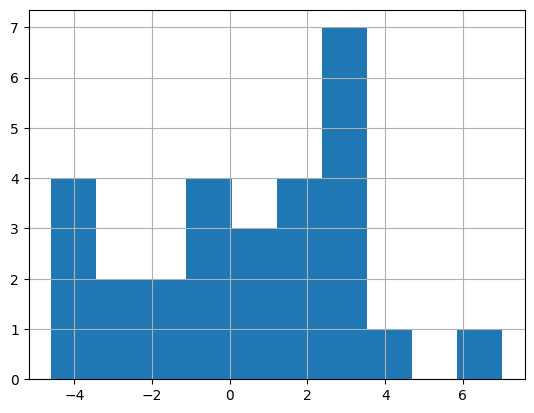

In [54]:
plotdf.query("ROI == 'Cerebelum_10_R'")['Anomaly Score'].hist()

<Axes: xlabel='Anomaly Score', ylabel='Count'>

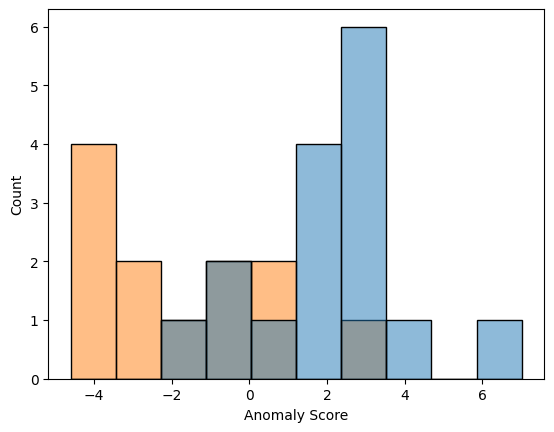

In [55]:
sns.histplot(data=plotdf.query("ROI == 'Cerebelum_10_R'"), x='Anomaly Score', hue='Subpopulation', bins=10, legend=False)

In [56]:
# Set the axis title font size using rcParams
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['figure.titlesize'] = 20
# plt.rcParams['axes.titlesize'] = 16
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "axes.titlesize":22})

/tmp/ipykernel_20498/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_20498/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_20498/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_20498/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)


Text(0.5, 1.02, 'Higher is Anomalous ($\\uparrow$)')

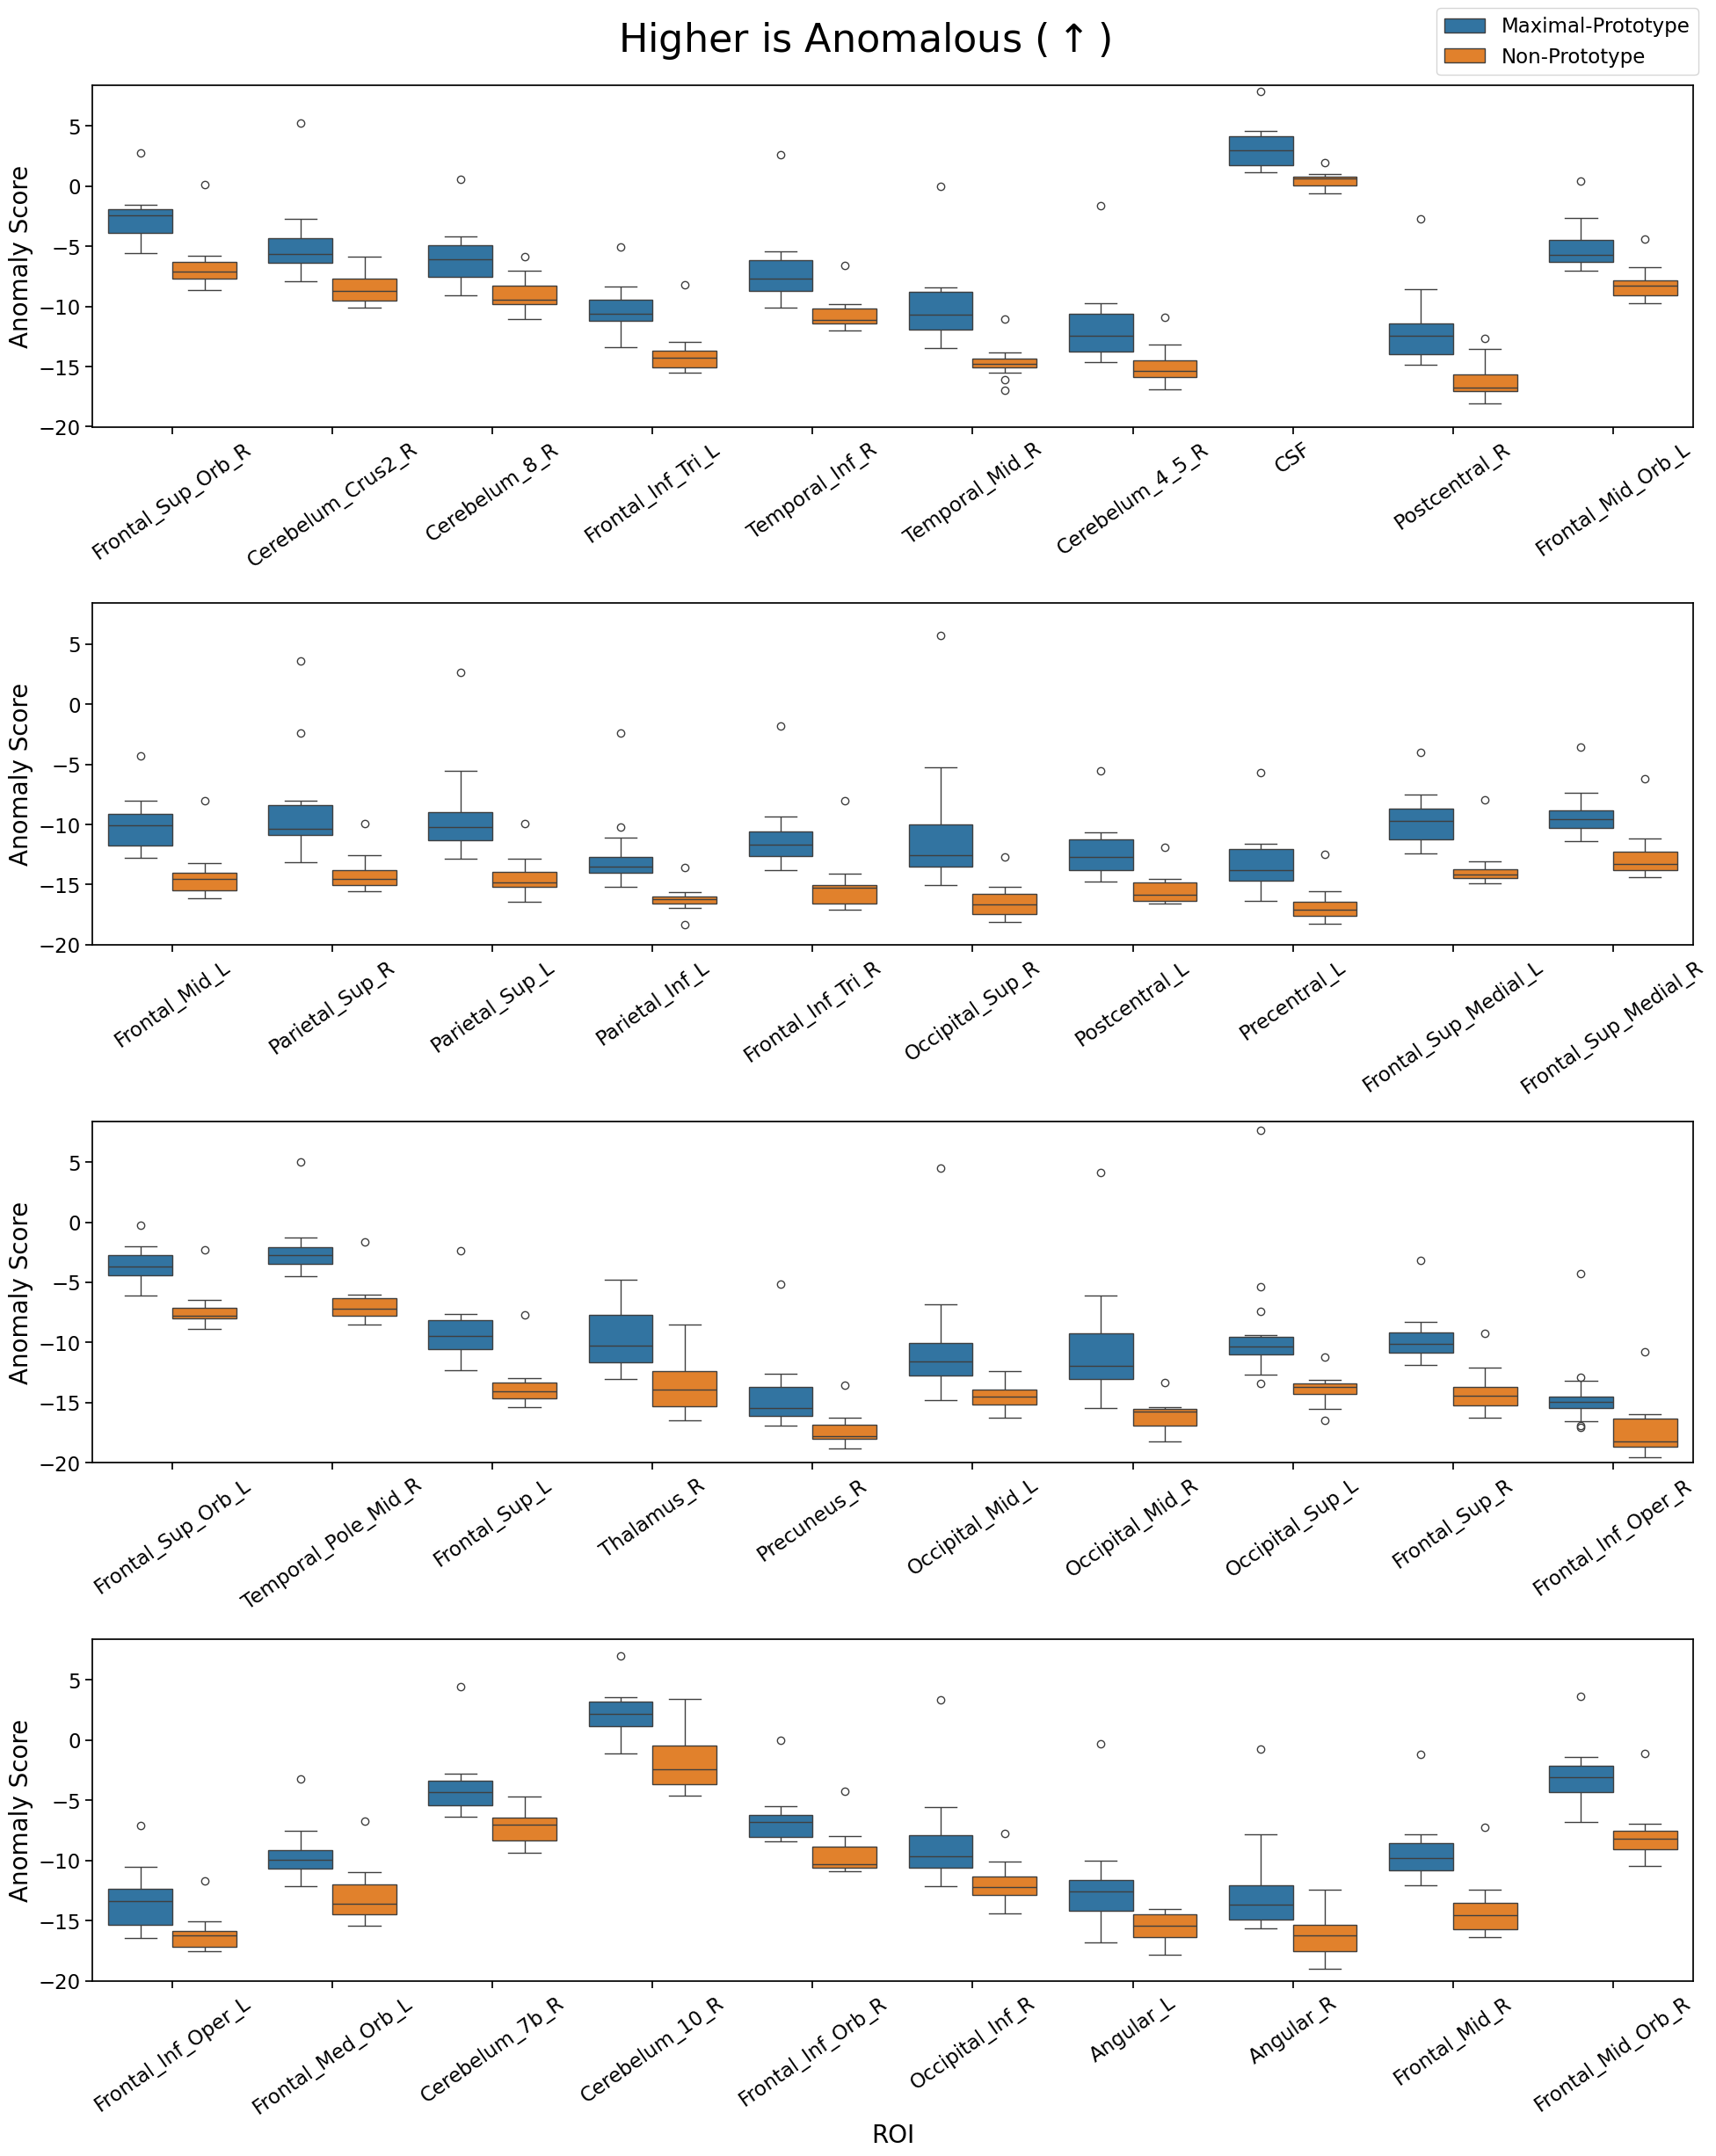

In [57]:
fig, axs = plt.subplots(4,1, figsize=(20, 24))
vmin, vmax = plotdf['Anomaly Score'].min()-0.5, plotdf['Anomaly Score'].max()+0.5
n_per_row = 10
rois_per_row = [roi_order[i:i+n_per_row] for i in range(0, len(roi_order), n_per_row) ]

for i, (ax, _rois) in enumerate(zip(axs, rois_per_row)):
    sns.boxplot(plotdf, x="ROI", y='Anomaly Score', hue='Subpopulation', order=_rois,
                orient='v', palette='tab10', ax=ax, legend=i==0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    ax.set_ylim(vmin, vmax)
    if i+1 < len(axs):
        ax.set_xlabel('')
        
    if i==0:
#         ax.legend_.remove()
        
#     if show_legend:
#         show_legend = False
        fig.legend(loc='upper right', bbox_to_anchor=(0.98, 1.03)) #fontsize='large')
        l = ax.legend()
        l.set_visible(False)

# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels,  loc='upper right', bbox_to_anchor=(0.98, 1.03),)
# plt.suptitle("ROIs that are Signficantly Different")
plt.tight_layout()
fig.suptitle(r"Higher is Anomalous ($\uparrow$)", y=1.02, fontsize=32)
# plt.tight_layout(w_pad=2, h_pad=2)
# plt.subplots_adjust(top=0.11)

# plt.savefig('figures/roi_full_boxplot.pdf', dpi=150, bbox_inches='tight')

In [58]:
def add_refline(data, q=0.9, **kws):
    roi = data.iloc[0]['ROI']
    protomedian = plotdf.query(f"Subpopulation == 'Maximal-Prototype' & ROI == '{roi}'")['Anomaly Score'].median()
    p = significant_prototype_rois.query(f"ROI == '{roi}'")['adjusted'].item()
    ax = plt.gca()
#     refline = reference_likelihoods[roi].quantile(0.99)
    refline = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[roi].quantile(q)
    ax.axvline(refline, c='red', linestyle='dashed', label=f'Inlier {int(q*100):d} %-tile')
    ax.axvline(protomedian, c='black', linestyle='-', label='Prototype 50 %-tile')
    ax.set_title(ax.get_title() + f' | p = {p:.3f}', fontsize=14)

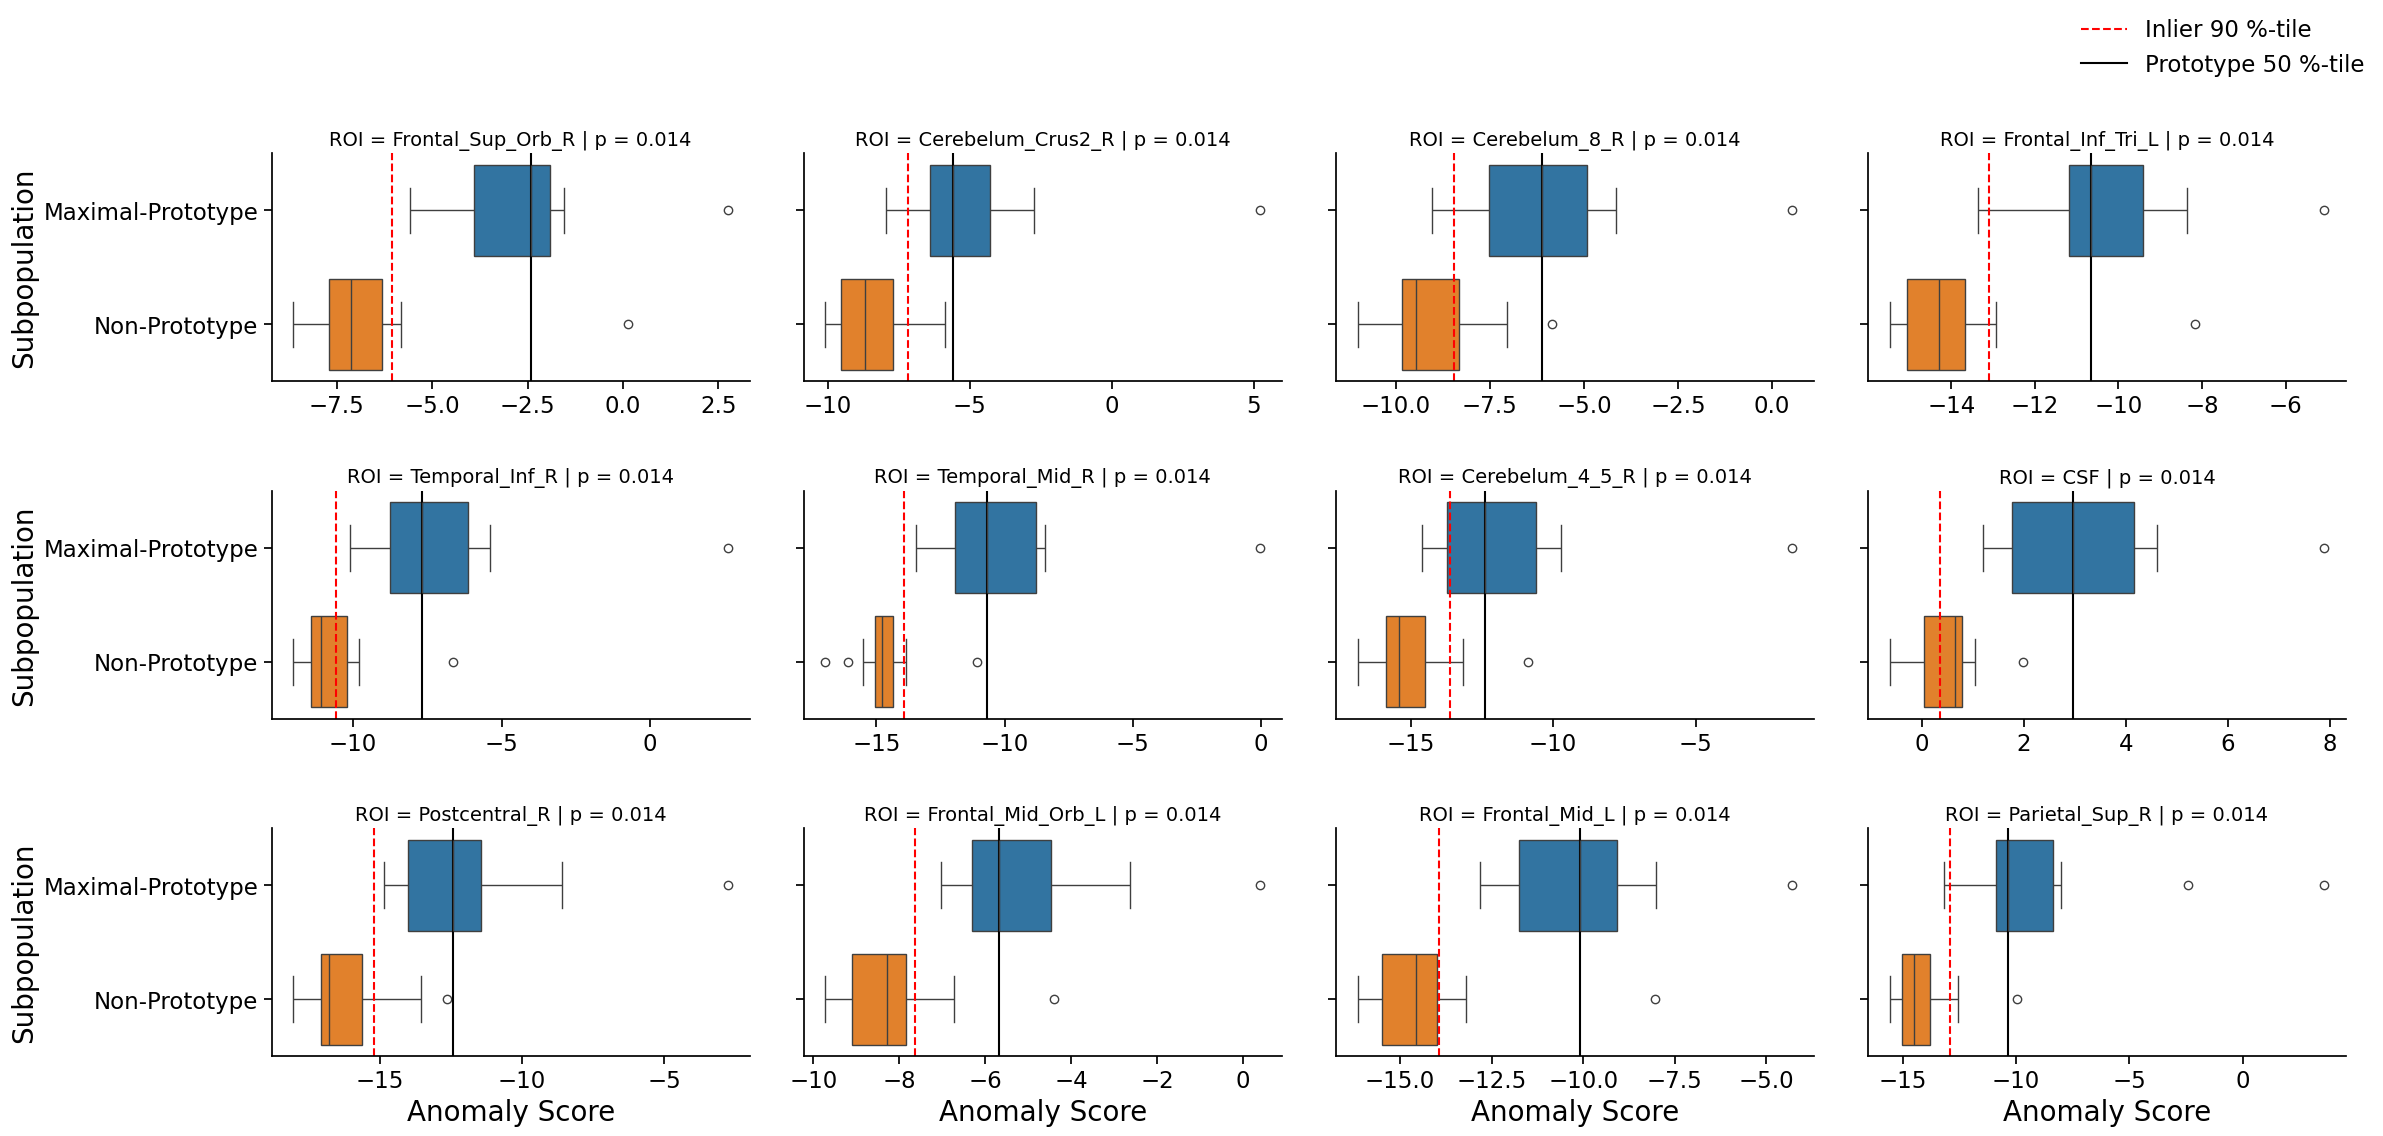

In [59]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=4, col_order=roi_order[:12],
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='tab10', orient='h')
g.map_dataframe(add_refline)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
plt.tight_layout(h_pad=2)

# plt.savefig('figures/roi_boxplot.pdf', dpi=150,  bbox_inches='tight')

In [60]:
q = 0.99
refqs = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[significant_prototype_rois["ROI"]].quantile(q)
protomedians = plotdf.query(f"Subpopulation == 'Maximal-Prototype'").groupby('ROI').median().loc[significant_prototype_rois["ROI"]]

higher_than_99 = [roi for roi in roi_order if protomedians.loc[roi].item() > refqs[roi].item()]
higher_than_99

/tmp/ipykernel_20498/3036443478.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  protomedians = plotdf.query(f"Subpopulation == 'Maximal-Prototype'").groupby('ROI').median().loc[significant_prototype_rois["ROI"]]


['Frontal_Sup_Orb_R',
 'Temporal_Inf_R',
 'Temporal_Mid_R',
 'CSF',
 'Postcentral_R',
 'Frontal_Mid_Orb_L',
 'Frontal_Mid_L',
 'Parietal_Sup_R',
 'Parietal_Sup_L',
 'Frontal_Inf_Tri_R',
 'Occipital_Sup_R',
 'Frontal_Sup_Medial_L',
 'Frontal_Sup_Orb_L',
 'Temporal_Pole_Mid_R',
 'Frontal_Sup_L',
 'Occipital_Mid_R',
 'Occipital_Sup_L',
 'Frontal_Sup_R',
 'Cerebelum_10_R',
 'Frontal_Inf_Orb_R',
 'Occipital_Inf_R',
 'Angular_R',
 'Frontal_Mid_R',
 'Frontal_Mid_Orb_R']

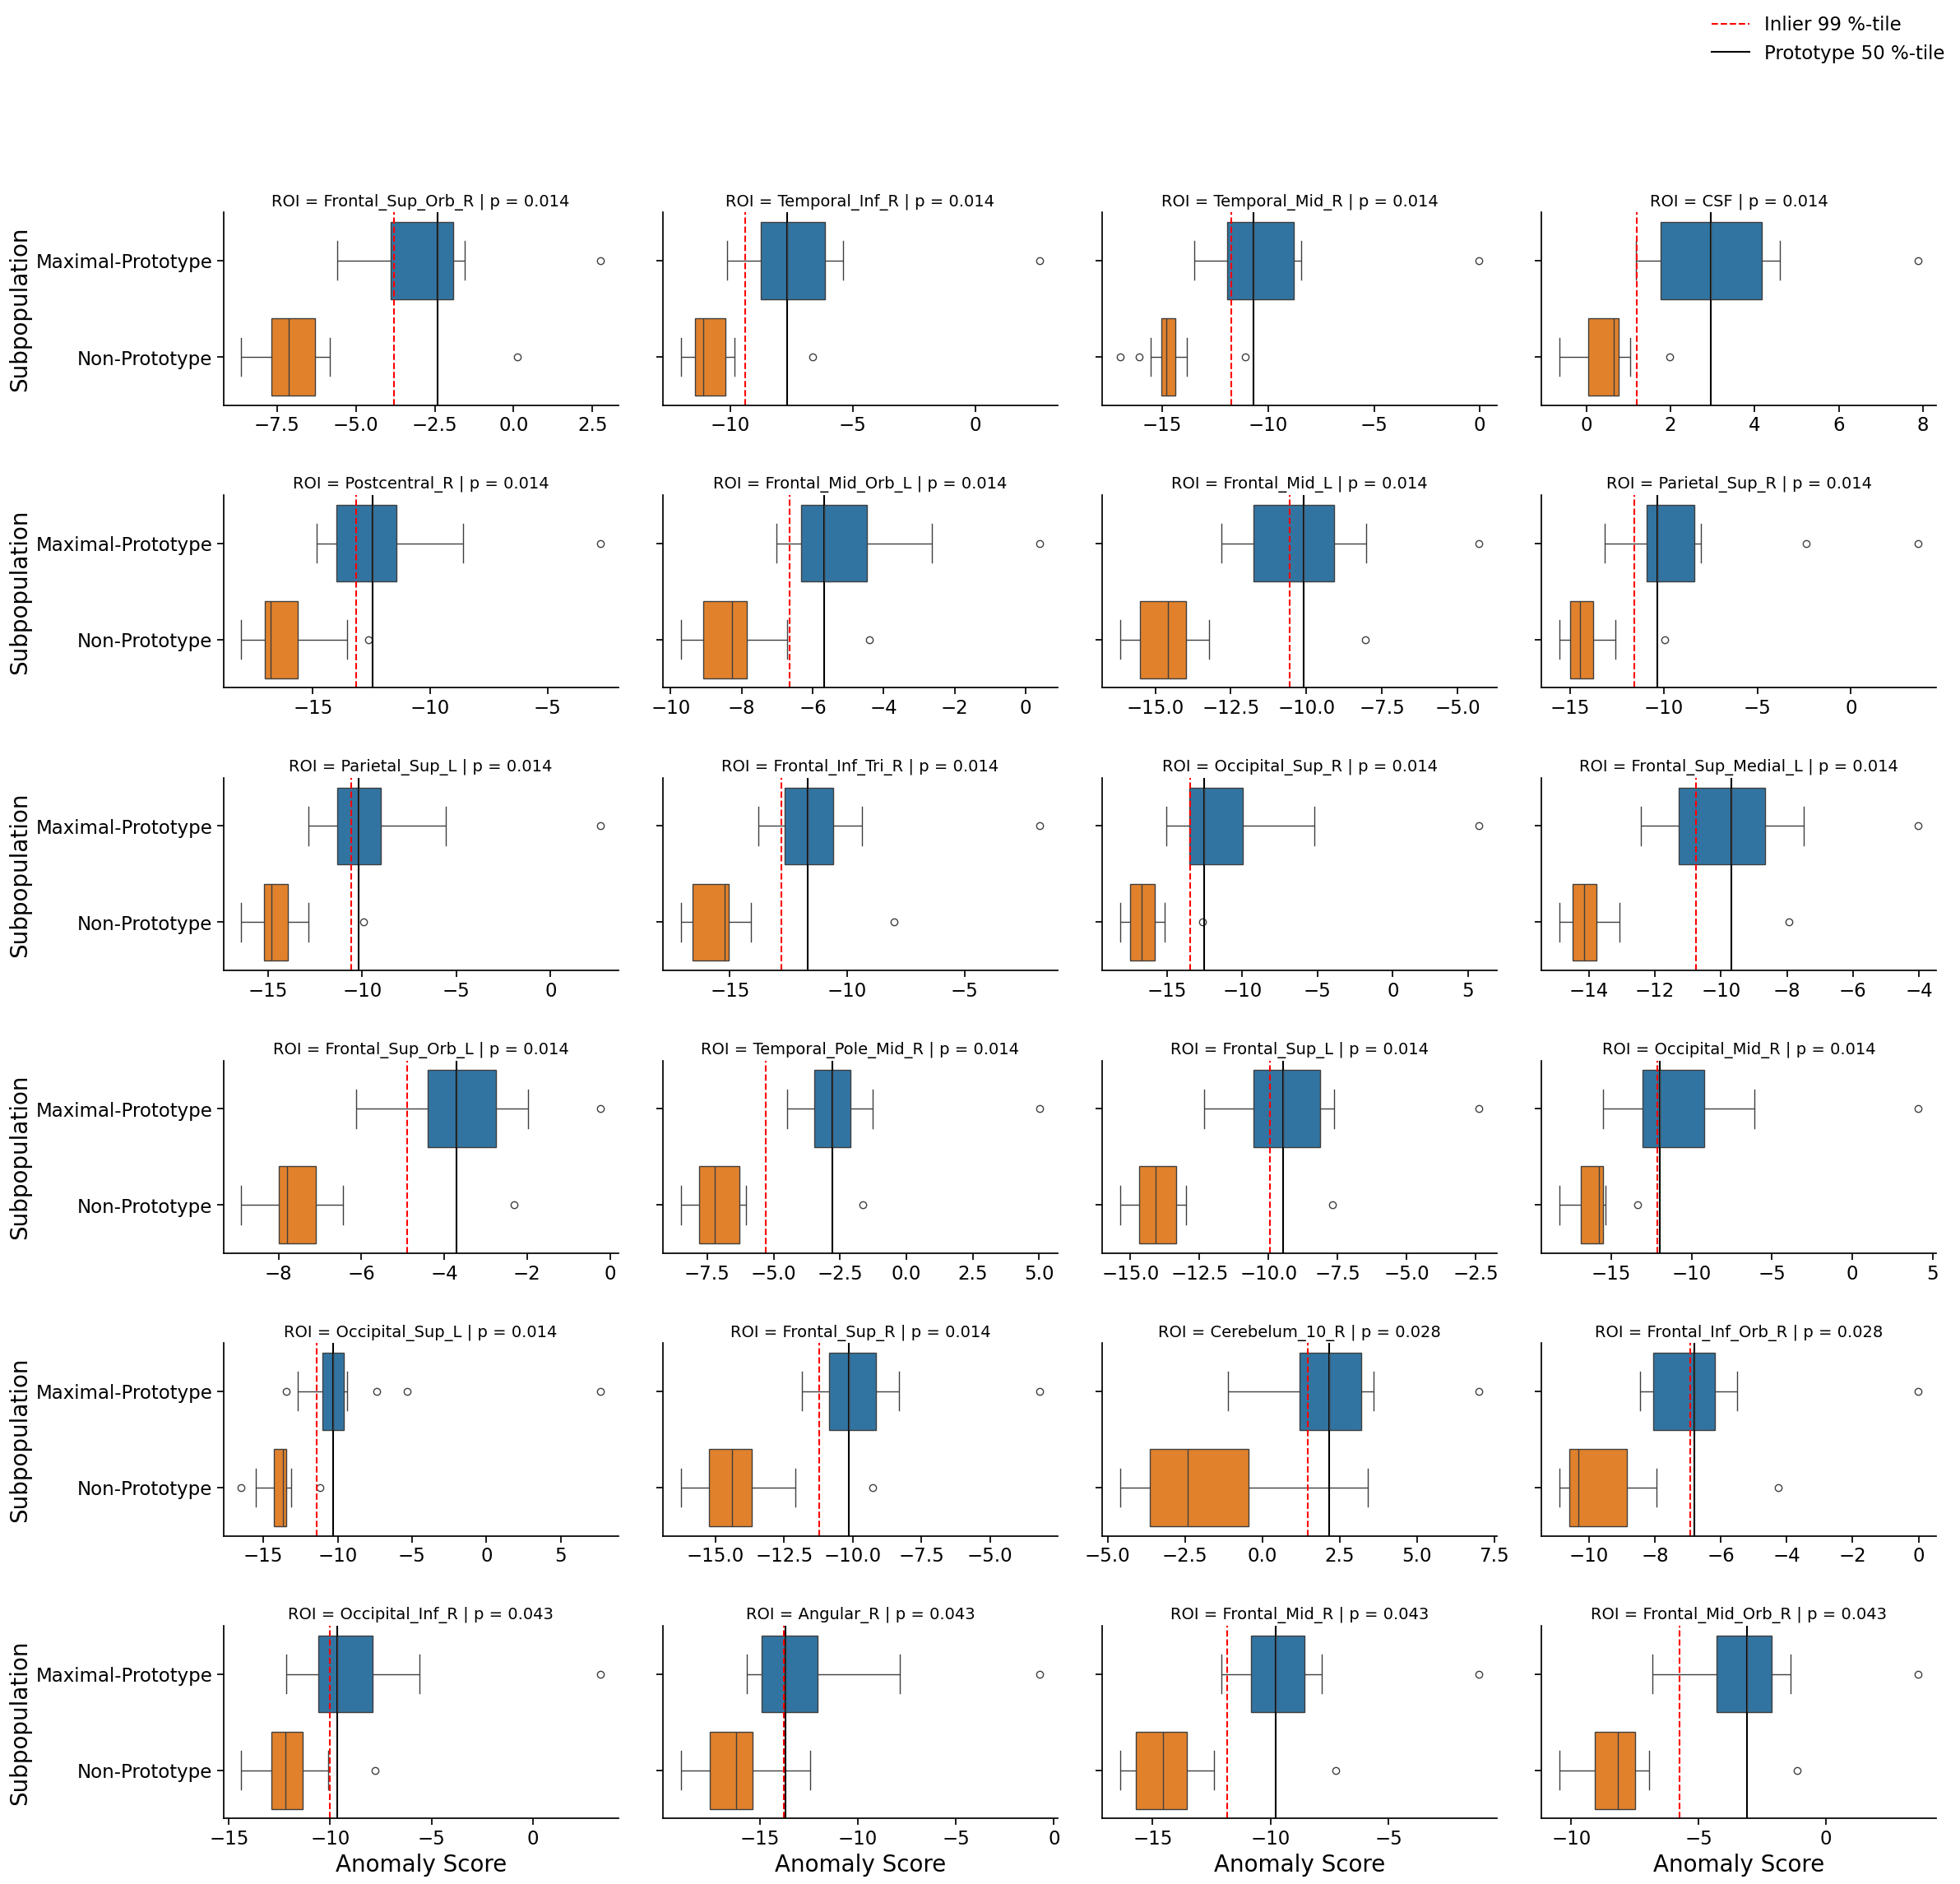

In [61]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=4, col_order=higher_than_99,
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='tab10', orient='h')
g.map_dataframe(add_refline, q=0.99)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
plt.tight_layout(h_pad=2)

### Sample 11 has missing values and 15 is an outlier in `depressed_percentile`

In [62]:
ds_prototypes[behavior_cols]

aggr_behav_T_score  anx_prob_T_score  anxious_T_score  \
0                 63.0              56.0             52.0   
1                 50.0              51.0             50.0   
2                 64.0              58.0             51.0   
3                 56.0              50.0             50.0   
4                 54.0              50.0             50.0   
5                 56.0              51.0             51.0   
6                 56.0              52.0             50.0   
7                 59.0              50.0             50.0   
8                 50.0              50.0             50.0   
9                 72.0              64.0             54.0   
10                59.0              52.0             52.0   
11                -1.0              -1.0             -1.0   
12                50.0              50.0             50.0   
13                56.0              50.0             50.0   
14                52.0              50.0             50.0   
15                51.0              51.0             50.0   

    attention_hyper_prob_T_score  attention_prob_T_score  \
0                           57.0                    59.0   
1                           51.0                    53.0   
2                           58.0                    61.0   
3                           57.0                    68.0   
4                           57.0                    59.0   
5                           75.0                    77.0   
6                           60.0                    62.0   
7                           60.0                    62.0   
8                           50.0                    55.0   
9                           66.0                    73.0   
10                          60.0                    70.0   
11                          -1.0                    -1.0   
12                          51.0                    52.0   
13                          51.0                    53.0   
14                          60.0                    64.0   
15                          50.0                    53.0   

    conduct_prob_T_score  depressed_T_score  depressive_prob_T_score  \
0                   56.0               56.0                     60.0   
1                   50.0               50.0                     52.0   
2                   57.0               50.0                     60.0   
3                   56.0               50.0                     52.0   
4                   52.0               50.0                     50.0   
5                   52.0               50.0                     60.0   
6                   63.0               50.0                     50.0   
7                   66.0               52.0                     52.0   
8                   52.0               60.0                     52.0   
9                   71.0               56.0                     56.0   
10                  56.0               56.0                     52.0   
11                  -1.0               -1.0                     -1.0   
12                  50.0               50.0                     50.0   
13                  56.0               52.0                     52.0   
14                  56.0               56.0                     50.0   
15                  54.0               68.0                     63.0   

    externalizing_T_score  internalizing_T_score  ...  \
0                    61.0                   50.0  ...   
1                    44.0                   41.0  ...   
2                    62.0                   50.0  ...   
3                    54.0                   43.0  ...   
4                    54.0                   39.0  ...   
5                    54.0                   43.0  ...   
6                    58.0                   43.0  ...   
7                    61.0                   43.0  ...   
8                    44.0                   52.0  ...   
9                    71.0                   58.0  ...   
10                   59.0                   54.0  ...   
11                   -1.0           

In [63]:
# missing = ds_prototypes.loc[11].ID
# clean_ds_prototypes = ds_prototypes[~ds_prototypes['ID'].isin([missing])]
# len(clean_ds_prototypes)

In [64]:
# clean_ds_prototypes = ds_prototypes[ds_prototypes.ID != ds_prototypes.loc[9].ID]
# len(clean_ds_prototypes)

In [ ]:
np.random.seed(42)
corrmatrix, sigcorrdf, rel_rois = run_correlation_analysis(ds_prototypes,
                                                           correlation_thresh=0.0,
                                                           relevant_roi_columns=list(significant_prototype_rois['ROI']),
                                                           n_resamples=10_000)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Running permutation test ... 
Correlation Threshold: 0.0
Feature Pairs: 1200 
Maximum DOF: 14 


143it [24:27, 10.27s/it]

In [81]:
sigcorrdf['nsamples'].unique()

array([15, 12])

In [82]:
corrmatrix.loc[significant_prototype_rois['ROI'], behavior_cols].stack()

Frontal_Sup_Orb_R  aggr_behav_T_score                       -0.426792
                   anx_prob_T_score                         -0.164924
                   anxious_T_score                          -0.389417
                   attention_hyper_prob_T_score             -0.627953
                   attention_prob_T_score                   -0.549488
                                                               ...   
Frontal_Mid_Orb_R  VSA DAS_SA,word_defn_ABILITY_SCORE        0.140314
                   Vineland_adapt_behave_comp_STD_SCORE     -0.075222
                   Vineland_communication_STD_SCORE          0.119381
                   Vineland_daily_living_skills_STD_SCORE   -0.268239
                   Vineland_socialization_STD_SCORE         -0.207258
Length: 1200, dtype: float64

In [83]:
corrmatrix.shape, sigcorrdf.shape

((82, 82), (1200, 6))

In [84]:
len(significant_prototype_rois['ROI']), len(behavior_cols)

(40, 42)

<Axes: >

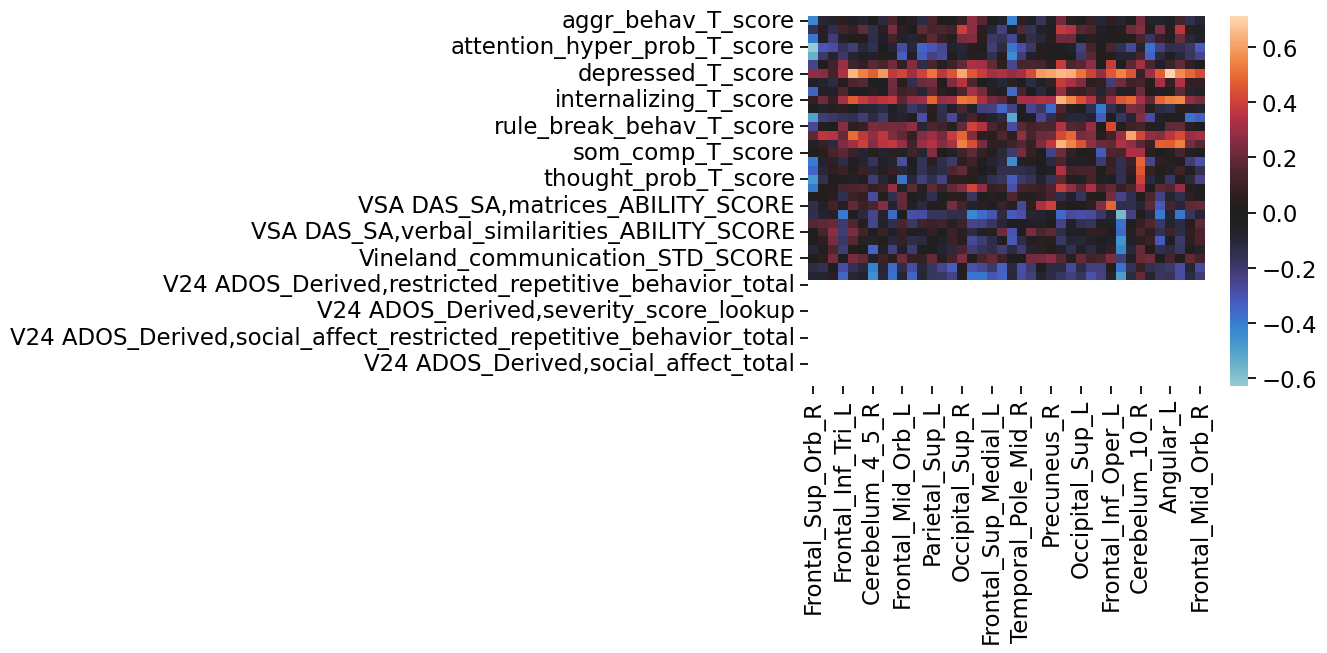

In [85]:
sns.heatmap(corrmatrix.loc[behavior_cols, roi_order], center=0)

In [86]:
sigcorrdf

ROI                          Behavior      Corr  \
1056            Angular_L                 depressed_T_score  0.710932   
306       Occipital_Mid_L                 depressed_T_score  0.648977   
756        Temporal_Inf_R                 depressed_T_score  0.644330   
309       Occipital_Mid_L             internalizing_T_score  0.639970   
314       Occipital_Mid_L               social_prob_T_score  0.638314   
...                   ...                               ...       ...   
191   Temporal_Pole_Mid_R             oppo_def_prob_T_score  0.001490   
908     Frontal_Inf_Orb_R             externalizing_T_score  0.001477   
207   Temporal_Pole_Mid_R  Vineland_communication_STD_SCORE  0.001474   
1167      Occipital_Inf_R  Vineland_communication_STD_SCORE  0.000000   
890        Cerebelum_10_R       VSA DAS_SA,PC_ABILITY_SCORE  0.000000   

       p-value  nsamples  adjusted-p  
1056  0.000200        15    0.239976  
306   0.008399        15    0.441037  
756   0.001000        15    0.287971  
309   0.010399        15    0.441037  
314   0.008199        15    0.441037  
...        ...       ...         ...  
191   0.727527        15    0.986240  
908   0.783122        15    0.991886  
207   0.446155        15    0.941412  
1167  0.993101        15    1.000000  
890   0.523348        15    0.974414  

[1200 rows x 6 columns]

In [ ]:
sns.heatmap(corrmatrix.loc[behavior_cols, roi_order], center=0)

In [90]:
# sigcorrdf.to_csv("./corr_pvals.csv"))
# corrmatrix.to_csv("./corrmatrix.csv")

In [113]:
corrmatrix = pd.read_csv("./corrmatrix.csv", index_col=0)
sigcorrdf = pd.read_csv("./corr_pvals.csv")
sigcorrdf.head(3)

ROI           Behavior      Corr   p-value  nsamples  \
0        Angular_L  depressed_T_score  0.710932  0.000200        15   
1  Occipital_Mid_L  depressed_T_score  0.648977  0.008399        15   
2   Temporal_Inf_R  depressed_T_score  0.644330  0.001000        15   

   adjusted-p  
0    0.239976  
1    0.441037  
2    0.287971

### Which Assessment shows high correlation with MSMA scores?

In [114]:
sigcorrdf['adjusted-p'] = false_discovery_control(sigcorrdf['p-value'], method='bh')
alpha = 0.01
print(f"Significant: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['p-value'] < alpha).sum()} / {len(sigcorrdf)}")
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.1
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.3
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")

Significant: 0.01 -> Significant ROI-Behavior Correlations: 25 / 1200
FDR: 0.01 -> Significant ROI-Behavior Correlations: 0 / 1200
FDR: 0.1 -> Significant ROI-Behavior Correlations: 0 / 1200
FDR: 0.3 -> Significant ROI-Behavior Correlations: 5 / 1200


In [123]:
(sigcorrdf['p-value'] < ONE_PERCENT).sum()

25

In [124]:
mask = sigcorrdf['p-value'] <= (ONE_PERCENT)
sigcorrdf[mask].groupby('Behavior').describe()

Corr                                          \
                            count      mean       std       min       25%   
Behavior                                                                    
VSA DAS_SA,rd_ABILITY_SCORE   6.0 -0.238448  0.180353 -0.572574 -0.264984   
depressed_T_score            12.0  0.576955  0.080535  0.432135  0.518485   
internalizing_T_score         4.0  0.517841  0.033868  0.481091  0.493341   
sluggish_cogn_tempo_T_score   1.0  0.610468       NaN  0.610468  0.610468   
social_prob_T_score           2.0  0.587369  0.072047  0.536424  0.561896   

                                                          p-value            \
                                  50%       75%       max   count      mean   
Behavior                                                                      
VSA DAS_SA,rd_ABILITY_SCORE -0.203316 -0.112497 -0.083718     6.0  0.004700   
depressed_T_score            0.586248  0.632714  0.710932    12.0  0.005683   
internalizing_T_score        0.519698  0.544198  0.550879     4.0  0.008499   
sluggish_cogn_tempo_T_score  0.610468  0.610468  0.610468     1.0  0.001200   
social_prob_T_score          0.587369  0.612842  0.638314     2.0  0.008599   

                             ... nsamples       adjusted-p            \
                             ...      75%   max      count      mean   
Behavior                     ...                                       
VSA DAS_SA,rd_ABILITY_SCORE  ...     12.0  12.0        6.0  0.390015   
depressed_T_score            ...     15.0  15.0       12.0  0.411526   
internalizing_T_score        ...     15.0  15.0        4.0  0.441037   
sluggish_cogn_tempo_T_score  ...     15.0  15.0        1.0  0.287971   
social_prob_T_score          ...     15.0  15.0        2.0  0.441037   

                                                                               \
                                  std       min       25%       50%       75%   
Behavior                                                                        
VSA DAS_SA,rd_ABILITY_SCORE  0.079043  0.287971  0.326238  0.441037  0.441037   
depressed_T_score            0.069677  0.239976  0.441037  0.441037  0.441037   
internalizing_T_score        0.000000  0.441037  0.441037  0.441037  0.441037   
sluggish_cogn_tempo_T_score       NaN  0.287971  0.287971  0.287971  0.287971   
social_prob_T_score          0.000000  0.441037  0.441037  0.441037  0.441037   

                                       
                                  max  
Behavior                               
VSA DAS_SA,rd_ABILITY_SCORE  0.441037  
depressed_T_score            0.441037  
internalizing_T_score        0.441037  
sluggish_cogn_tempo_T_score  0.287971  
social_prob_T_score          0.441037  

[5 rows x 32 columns]

In [117]:
# # plt.Figure(dpi=100)
# g = sns.FacetGrid(sigcorrdf[mask], col_wrap=2, col="Behavior", height=4.5, aspect=2,
#                   sharex=False, sharey=False, despine=False)
# g.map(sns.barplot, "ROI", "Corr")

In [118]:
# dsdata = datadf.query("Cohort == 'IBIS-DS'")
# dsdata.loc[:, 'Prototypical'] = False
# dsdata.loc[dsdata['ID'].isin(ds_prototypes['ID']), 'Prototypical'] = True
# dsdata['Prototypical'].value_counts()

In [119]:
ref_max = reference_likelihoods.quantile(0.99)

In [120]:
sigcorrdf

ROI                          Behavior      Corr  \
0               Angular_L                 depressed_T_score  0.710932   
1         Occipital_Mid_L                 depressed_T_score  0.648977   
2          Temporal_Inf_R                 depressed_T_score  0.644330   
3         Occipital_Mid_L             internalizing_T_score  0.639970   
4         Occipital_Mid_L               social_prob_T_score  0.638314   
...                   ...                               ...       ...   
1195  Temporal_Pole_Mid_R             oppo_def_prob_T_score  0.001490   
1196    Frontal_Inf_Orb_R             externalizing_T_score  0.001477   
1197  Temporal_Pole_Mid_R  Vineland_communication_STD_SCORE  0.001474   
1198      Occipital_Inf_R  Vineland_communication_STD_SCORE  0.000000   
1199       Cerebelum_10_R       VSA DAS_SA,PC_ABILITY_SCORE  0.000000   

       p-value  nsamples  adjusted-p  
0     0.000200        15    0.239976  
1     0.008399        15    0.441037  
2     0.001000        15    0.287971  
3     0.010399        15    0.441037  
4     0.008199        15    0.441037  
...        ...       ...         ...  
1195  0.727527        15    0.986240  
1196  0.783122        15    0.991886  
1197  0.446155        15    0.941412  
1198  0.993101        15    1.000000  
1199  0.523348        15    0.974414  

[1200 rows x 6 columns]

In [126]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 22, "axes.titlesize":22, 'axes.labelweight':'bold'})
fig, axs = plt.subplots(5,5, figsize=(35, 30),)
show_legend = True
for ax, row in zip(axs.flat, sigcorrdf[mask].sort_values(by='adjusted-p').iterrows()):
    ax.set_ymargin(0.01)
    idx, (roi, bhv, corr, p, n, ap) = row
    non_missing_samples = ds_prototypes[bhv] > -1
    sns.scatterplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, style='Sex', hue='Sex',
                    palette='tab10', style_order=["Male", "Female"], #markers=['X','D'],
                    ax=ax, legend=show_legend, s=200, alpha=1)
    sns.regplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, scatter=False,
                color='black', ci=None, robust=True, truncate=True, ax=ax)
    ymin,ymax = ax.get_ylim()
    if ymin < 0:
        ax.set_ylim(0, None)
    ax.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
#     ax.set_title(f"Correlation: {corr:.3f} - p<{p:.3f}")
#     ax.xaxis.label.set_fontsize(14)
#     ax.yaxis.label.set_fontsize(14)
    
    text_box = ax.text(0.65, 0.4, f"r = {corr:.3f}\np = {ap:.3f}", 
                       transform=ax.transAxes,
                       fontsize=20, color='white', 
                       bbox={'facecolor':'tab:blue', 'alpha':0.5,
                             'boxstyle':"round,pad=0.5"}
                      )
    
    if show_legend:
        show_legend = False
        fig.legend(loc='upper right', fontsize='large')
        
    l = ax.legend()
    l.set_visible(False)

# plt.suptitle("Significant Correlations", fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.9)
plt.savefig('figures/regplot.pdf', dpi=150)
plt.close()

In [ ]:
# ds_prototypes[[roi, bhv]]

In [131]:
def plot_roi_regression(rows, axs, fig):
    show_legend = True
    for (ax1,ax2), row in zip(axs, rows):

        idx, (roi, bhv, corr, p, n, ap) = row
        non_missing_samples = ds_prototypes[bhv] > -1
        sns.scatterplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, style='Sex', hue='Sex',
                        palette='tab10', style_order=["Male", "Female"], #markers=['X','D'],
                        ax=ax1, legend=show_legend, s=200, alpha=1)
        ax1.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
        sns.regplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, scatter=False,
                    color='black', ci=None, robust=True, truncate=True, ax=ax1)
        ymin,ymax = ax1.get_ylim()
        if ymin < 0:
            ax1.set_ylim(0, None)
        ylab = ax1.get_ylabel().replace("_percentile", "").replace("_PERCENTILE", "")
        ax1.set_ylabel(ylab)

        rowdf = ds_prototypes[non_missing_samples].copy()
        rowdf[[roi, bhv]] = rowdf[[roi, bhv]].apply(rankdata)

        sns.scatterplot(rowdf, x=roi, y=bhv, style='Sex', hue='Sex', palette='tab10', style_order=["Male", "Female"],
                        ax=ax2, legend=False, s=150, alpha=0.8)
        sns.regplot(rowdf, x=roi, y=bhv, scatter=False, color='black', ci=None,  ax=ax2,
    #                robust=True, truncate=True,
                   )
        ytext = 0.3 if corr < 0 else 0.7
        text_box = ax2.text(0.05, ytext, f"r = {corr:.3f}\np < {ap:.3f}", 
                           transform=ax2.transAxes,
                           fontsize=18, color='white', 
                           bbox={'facecolor':'tab:blue', 'alpha':0.5,
                                 'boxstyle':"round,pad=0.3"}
                          )
        ylab = ax2.get_ylabel().replace("percentile", "rank").replace("PERCENTILE", "rank")
        ylab = ax2.get_ylabel().replace("T_score", "rank")
        
        ax2.set_ylabel(ylab)

        if show_legend:
            show_legend = False
            fig.legend(loc='upper right', fontsize='large')

        for ax in [ax1,ax2]:
            l = ax.legend()
            l.set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

saved


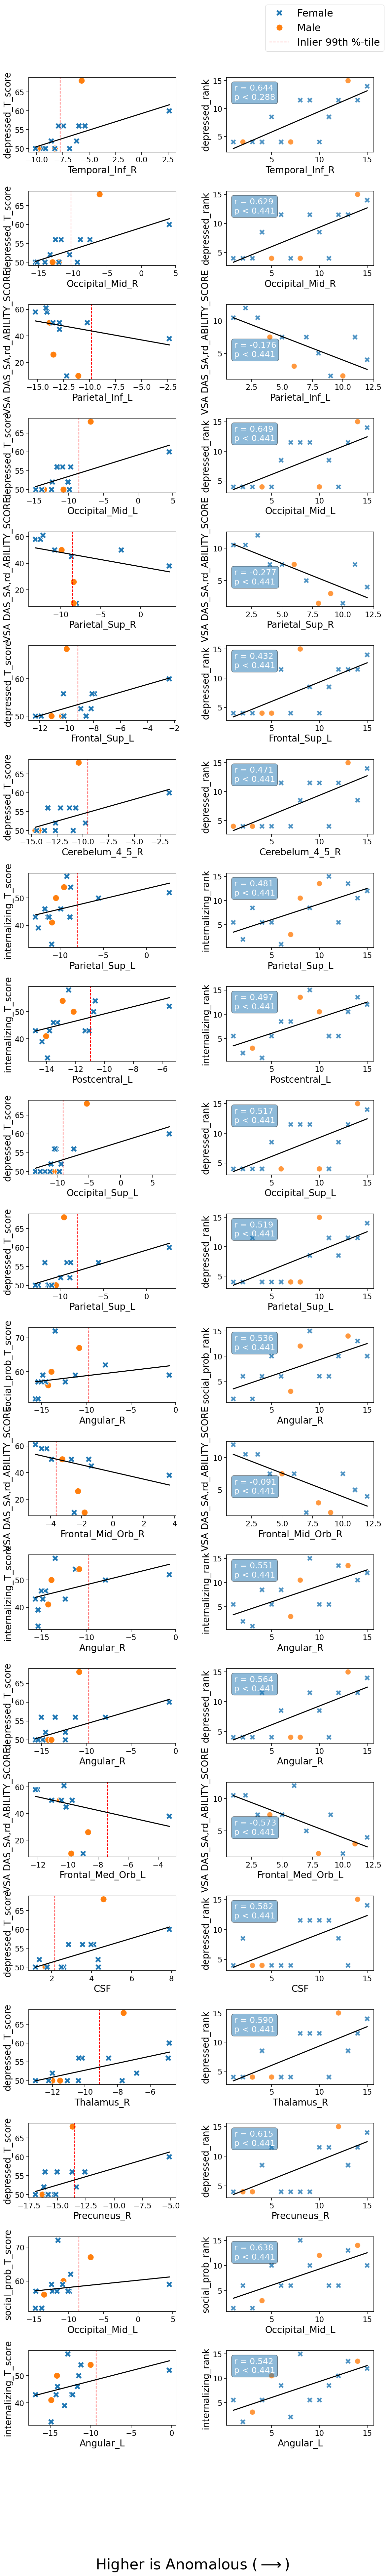

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "figure.titlesize":36, 'axes.labelweight':'bold'})
rows =  list(sigcorrdf[mask].sort_values(by='adjusted-p').iterrows())

nrows = 4
fig, axs = plt.subplots(nrows,2, figsize=(12, 4.1*nrows),)
figrows =  rows[:nrows]

plot_roi_regression(figrows, axs, fig)

# Add a label below the subplots
fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('figures/rankcorrplot-fig1.pdf', dpi=150);
plt.close()

fig, axs = plt.subplots(len(rows)-nrows, 2, figsize=(12, 3.8 *(len(rows)-nrows)),)
# show_legend = True
figrows =  rows[nrows:]

plot_roi_regression(figrows, axs, fig)

# Add a label below the subplots
fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.97, bottom=0.08)
plt.savefig('figures/rankcorrplot-fig2.pdf', dpi=150);
# plt.close()
print('saved')

In [150]:
pmatrix = corrmatrix.copy() * 0 + 0.2
corrected_pmatrix = corrmatrix.copy() * 0 + 0.2

for row in sigcorrdf.iterrows():
    idx, (roi, bhv, corr, p, n, ap) = row
    pmatrix.loc[roi, bhv] = p
    pmatrix.loc[bhv, roi] = p
    
    corrected_pmatrix.loc[roi, bhv] = ap
    corrected_pmatrix.loc[bhv, roi] = ap

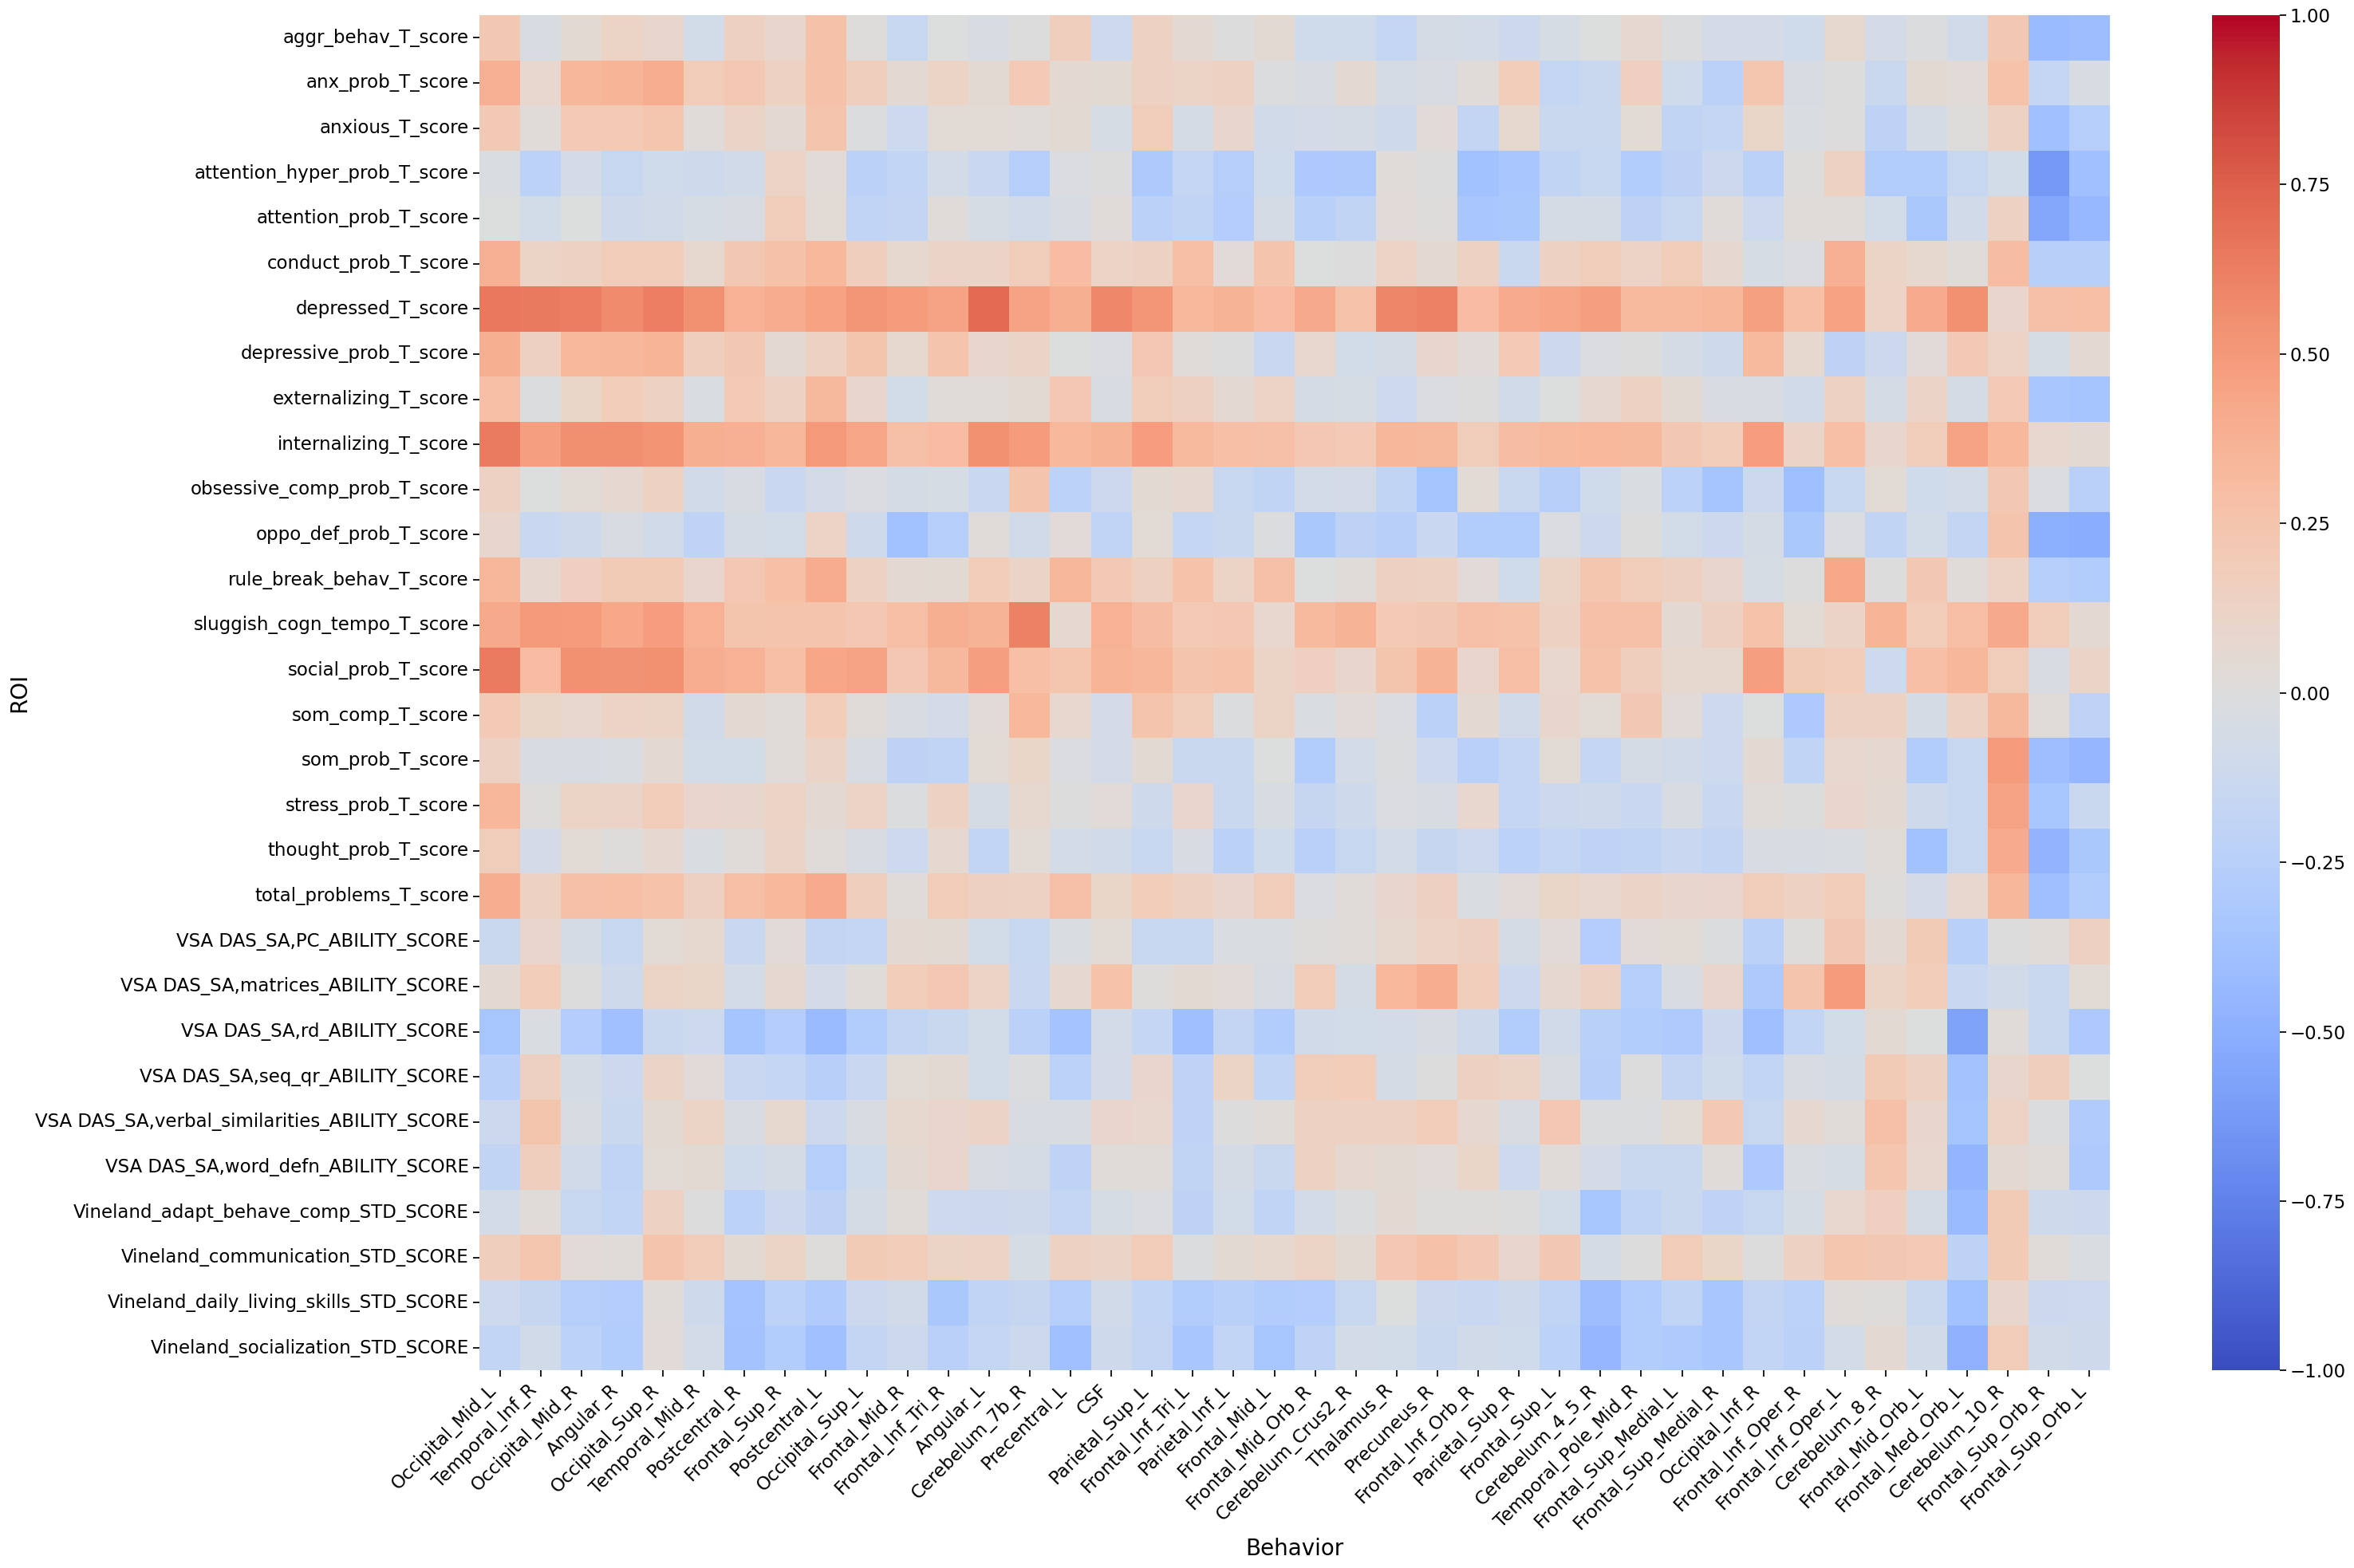

In [151]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
# corrs = corrmatrix.loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
relevant_behaviors = corrmatrix.loc[behavior_cols].mean(1).dropna().index
relevant_rois = corrmatrix.loc[list(significant_prototype_rois['ROI'])].mean(1).sort_values(ascending=False).index

sns.heatmap(corrmatrix.loc[relevant_behaviors, relevant_rois], cmap='coolwarm', vmin=-1, vmax=1, ax=axs, annot=False)
# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/full_corrmatrix.pdf', dpi=150)

### p-value Matrix

In [152]:
pmin, pmax = 0.0001, thresh
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(pmin)), 1+math.ceil(math.log10(pmax)))]
cbar_ticks

[0.0001, 0.001, 0.01, 0.1]

In [153]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
thresh = 0.1
pmin = 0.0001
log_norm = LogNorm(vmin=pmin, vmax=pmax)
significant_ps = pmatrix.loc[relevant_behaviors, relevant_rois] < thresh

sns.heatmap(pmatrix.loc[relevant_behaviors, relevant_rois]*significant_ps, ax=axs, annot=False,
            fmt=".3f",
            norm=log_norm,
            mask=~significant_ps,
#             vmin=0.001, vmax=0.1,
            cmap='rocket', 
            cbar_kws={'ticks': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1], 'extend':'max'}
           )
# sns.heatmap(pmatrix[significant_ps].loc[relevant_behaviors, relevant_rois], ax=axs, annot=False)
axs.set_facecolor("seashell")
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/pmatrix.pdf', dpi=150)
plt.close()

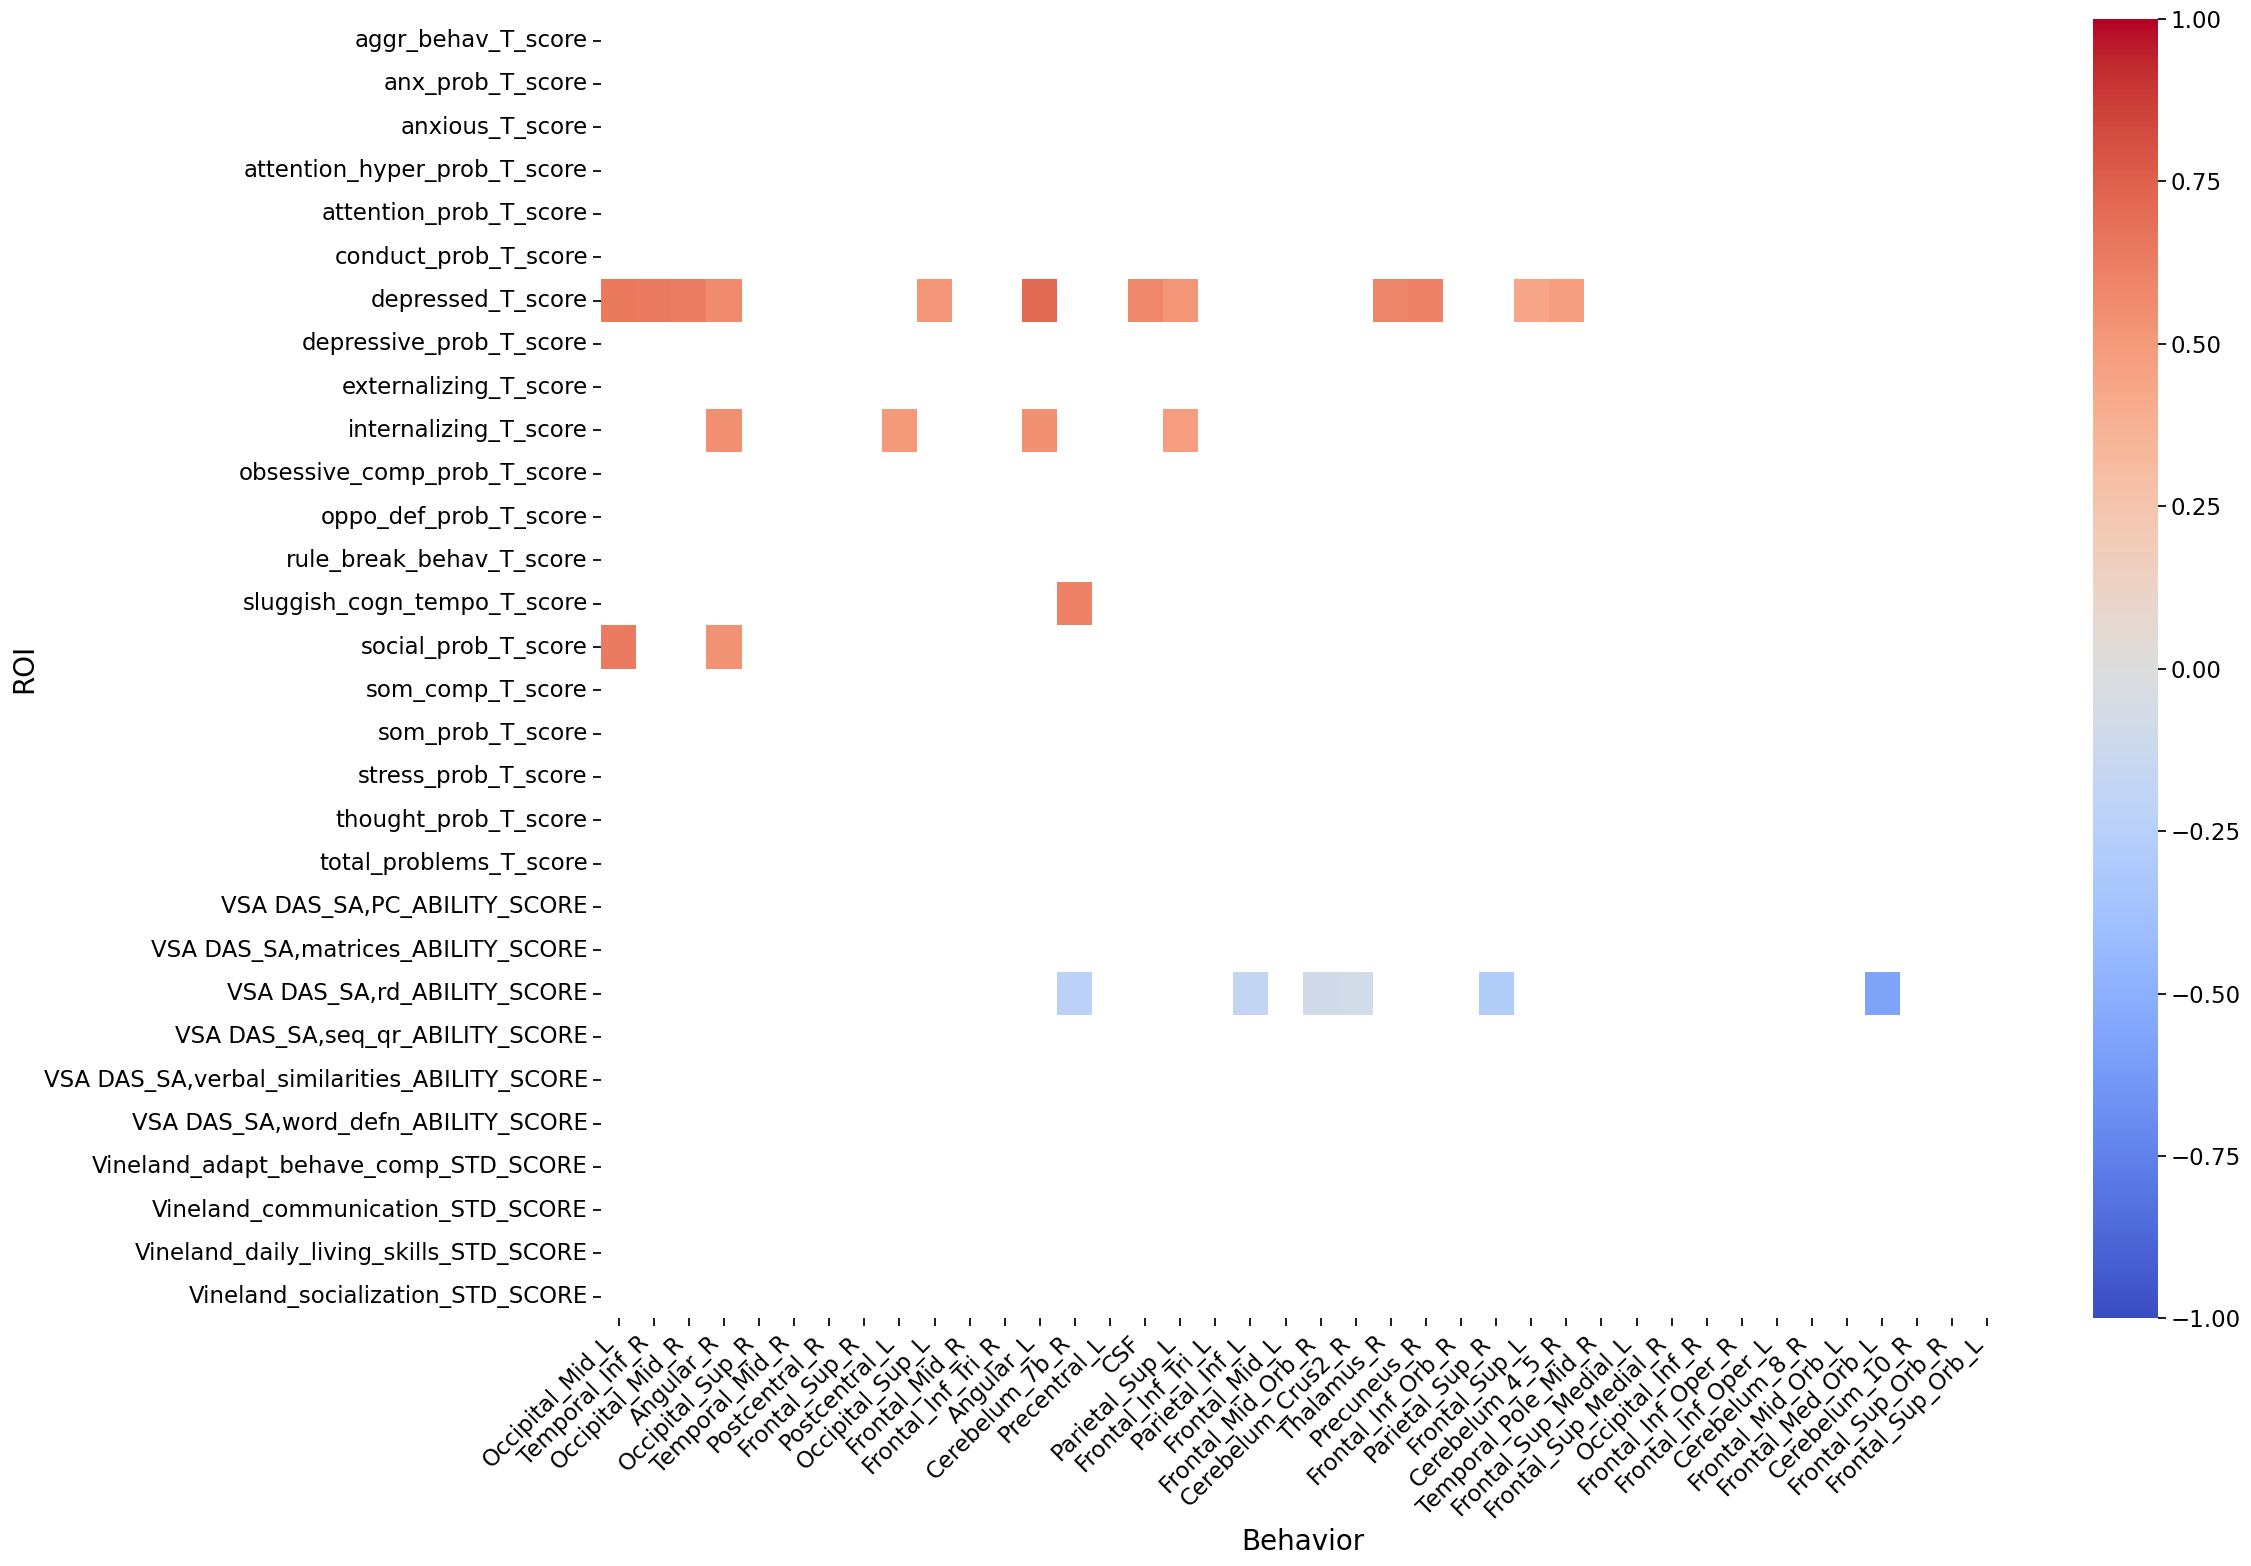

In [142]:
fig, axs = plt.subplots(1,1, figsize=(24,16))
# corrs = corrmatrix.loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
relevant_behaviors = corrmatrix.loc[behavior_cols].mean(1).dropna().index
relevant_rois = corrmatrix.loc[list(significant_prototype_rois['ROI'])].mean(1).sort_values(ascending=False).index

pmask = pmatrix.loc[relevant_behaviors, relevant_rois] > 0.01
sns.heatmap(corrmatrix.loc[relevant_behaviors, relevant_rois], cmap='coolwarm', vmin=-1, vmax=1, ax=axs, mask=pmask)
# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
# plt.savefig('figures/full_corrmatrix.pdf', dpi=150)

Text(358.25, 0.5, 'ROI')

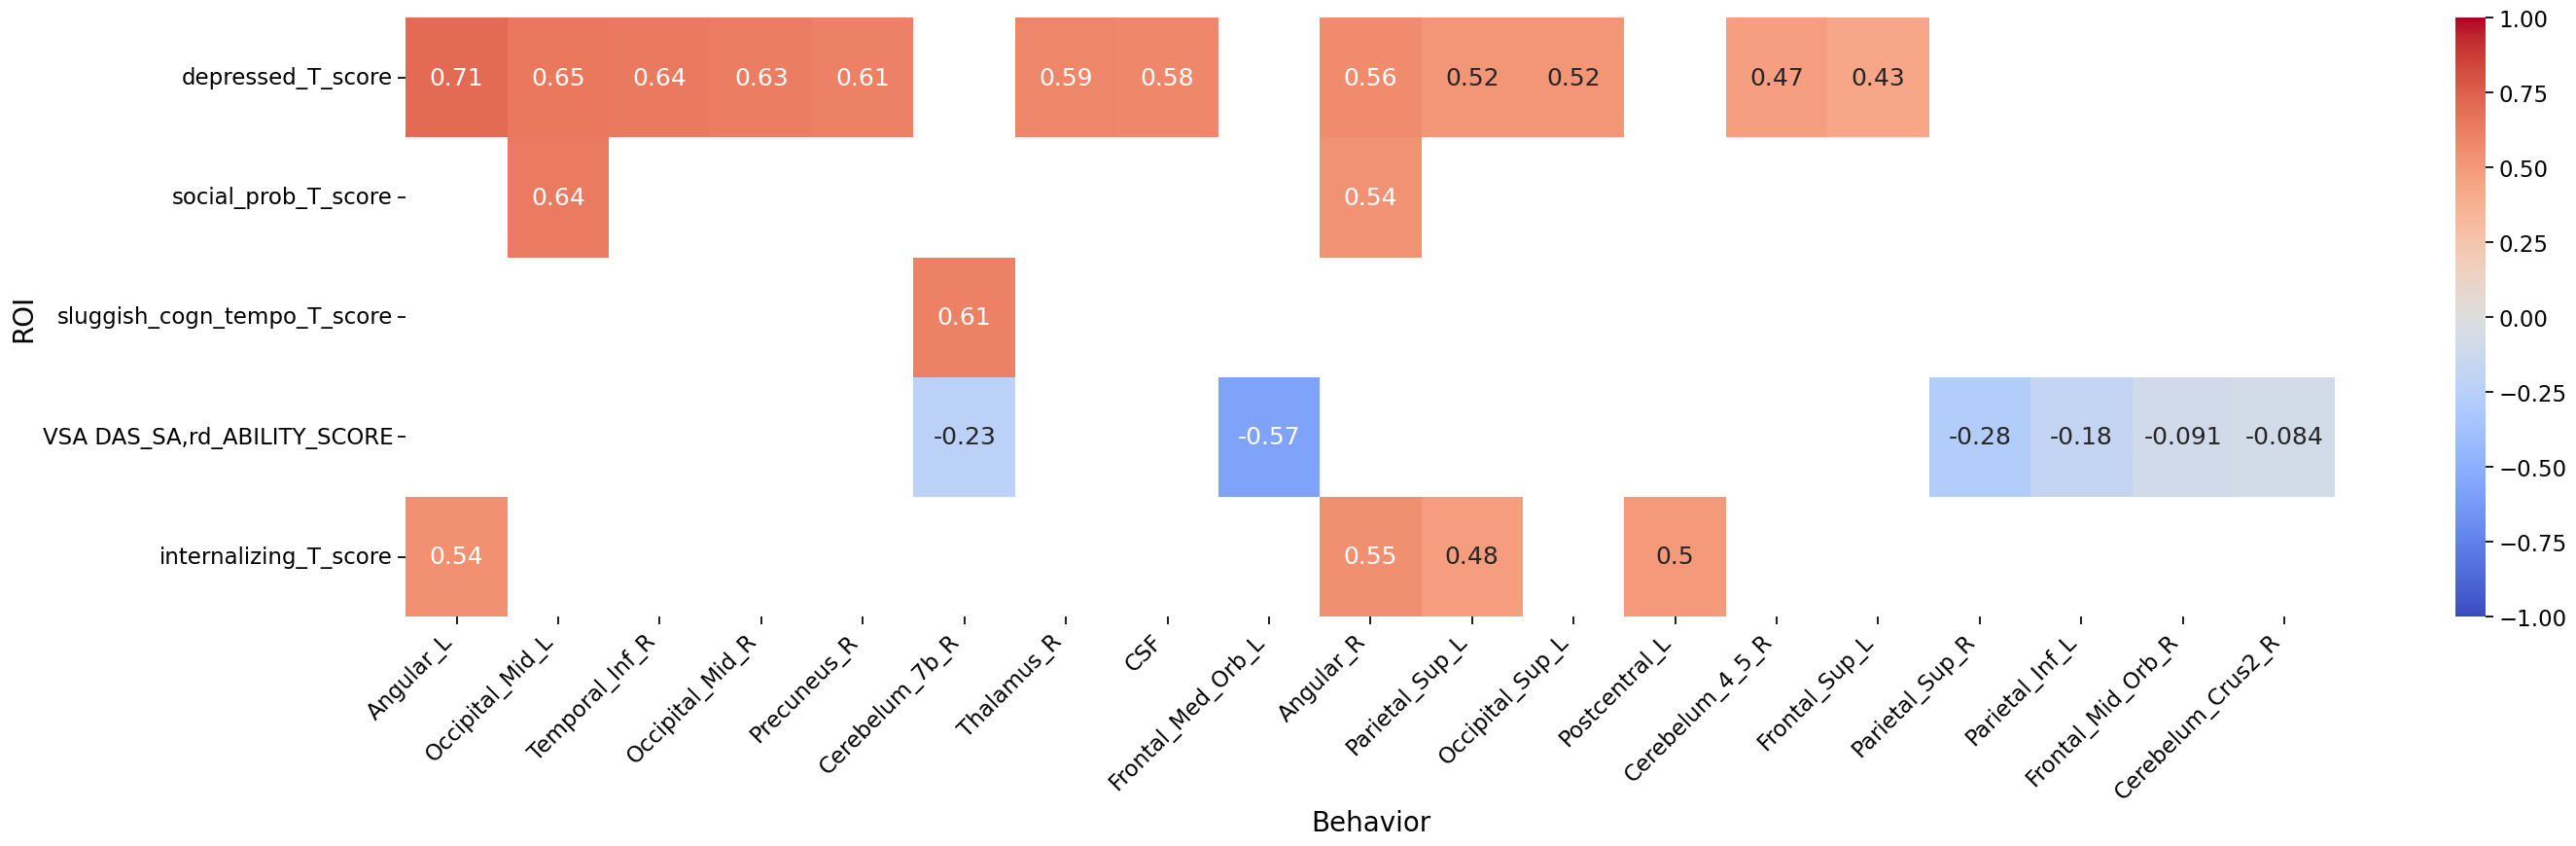

In [143]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
thresh = 0.01
significant_correlation = pmatrix < thresh

relcorrs = sigcorrdf[sigcorrdf['p-value'] < thresh]
# corrs = corrmatrix[significant_correlation].loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 1].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 1].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[significant_correlation].loc[relevant_behaviors, relevant_rois],
            cmap='coolwarm', vmin=-1, vmax=1, ax=axs, annot=True)
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")

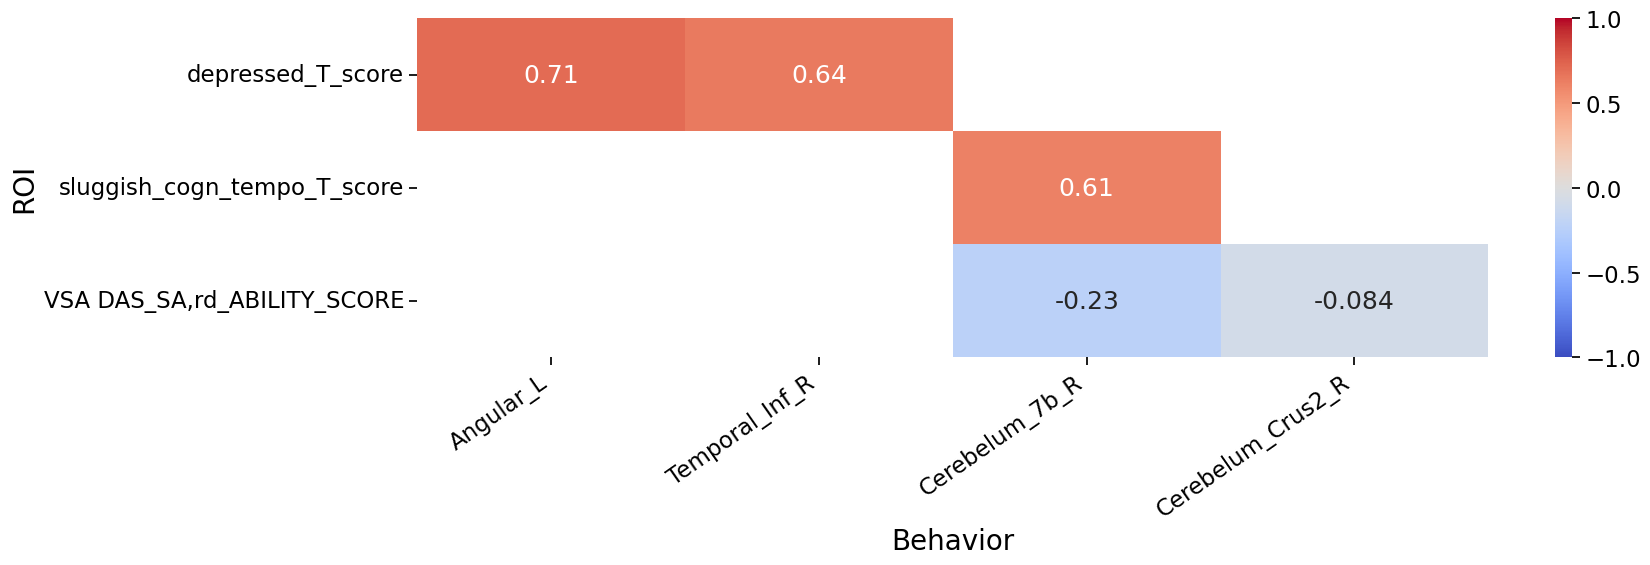

In [156]:
fig, axs = plt.subplots(1,1, figsize=(18,6))
# sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
# axs[0].set_xticks([])
thresh = TEN_PERCENT * 3
relcorrs = sigcorrdf[sigcorrdf['adjusted-p'] < thresh]
# corrs = corrmatrix[corrected_pmatrix < TEN_PERCENT].loc[relcorrs['ROI'].unique(), relcorrs['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 0].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 0].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[corrected_pmatrix < thresh].loc[relevant_behaviors, relevant_rois],
            annot=True,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axs,)
# axs.set_title(f"Significant Correlations (corrected-p < {TEN_PERCENT})", pad=20)
plt.xticks(rotation=35, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/sig_roi_corrs.pdf', dpi=150)

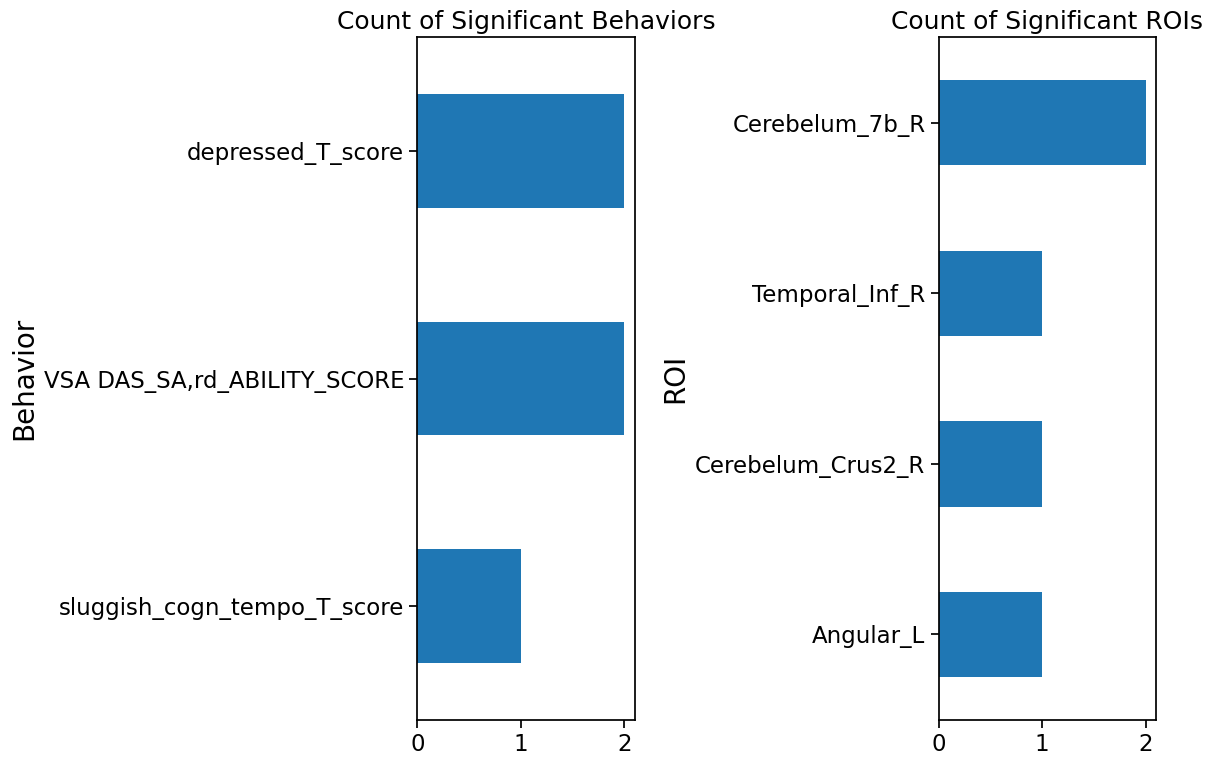

In [146]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
relcorrs.groupby('Behavior')['ROI'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[0])
axs[0].set_title(f"Count of Significant Behaviors")
# plt.xticks(rotation=45, ha='right');

relcorrs.groupby('ROI')['Behavior'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[1])
axs[1].set_title(f"Count of Significant ROIs")
# axs[1].set_xticks(rotation=45, ha='right');
plt.tight_layout()
# plt.title("Number Behavior/ROIs in a Significant Pair")

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 22, "axes.titlesize":22, 'axes.labelweight':'bold'})
fig, axs = plt.subplots(5,5, figsize=(35, 30),)
show_legend = True
rawpmask = sigcorrdf['p-value'] < 0.01

for ax, row in zip(axs.flat, sigcorrdf[rawpmask].sort_values(by='p-value').iterrows()):
    idx, (roi, bhv, corr, p, n, ap) = row
    non_missing_samples = ds_prototypes[bhv] > -1
    sns.scatterplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, style='Sex', hue='Sex',
                    palette='tab10', style_order=["Male", "Female"], #markers=['X','D'],
                    ax=ax, legend=show_legend, s=200, alpha=1)
    sns.regplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, scatter=False, color='black', ci=None,  ax=ax)
    
    ax.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
#     ax.set_title(f"Correlation: {corr:.3f} - p<{p:.3f}")
#     ax.xaxis.label.set_fontsize(14)
#     ax.yaxis.label.set_fontsize(14)
    
    text_box = ax.text(0.65, 0.4, f"r = {corr:.3f}\np = {ap:.3f}", 
                       transform=ax.transAxes,
                       fontsize=20, color='white', 
                       bbox={'facecolor':'tab:blue', 'alpha':0.5,
                             'boxstyle':"round,pad=0.5"}
                      )
    
    if show_legend:
        show_legend = False
        fig.legend(loc='upper right', fontsize='large')
        
    l = ax.legend()
    l.set_visible(False)

# plt.suptitle("Significant Correlations", fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.9)